# UMAP Performance Analysis: JavaScript vs WebAssembly Features

## Research Questions

**RQ1**: What is the performance impact of individual WASM features (Distance, Tree, Matrix, NN Descent, Optimizer) compared to pure JavaScript?

**RQ2**: How does enabling all WASM features together compare to individual features and pure JavaScript?

## Methodology

- **Test Environment**: All benchmarks run on WSL2 (Windows Subsystem for Linux)
- **Baseline**: Pure JavaScript UMAP implementation (no WASM)
- **Individual Features**: Each WASM feature enabled separately (Dist, Tree, Matrix, NN, Opt)
- **All Features**: All WASM features enabled simultaneously
- **Metrics**: Runtime (ms), Memory (MB), Quality (trustworthiness), FPS, Responsiveness (ms)
- **Statistical Analysis**: Mann-Whitney U tests, bootstrap confidence intervals, effect sizes

## 1. Setup and Data Loading

In [134]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# Statistical analysis
from scipy import stats
from scipy.stats import mannwhitneyu, bootstrap

# Set styling for publication-quality figures
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 3)

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All dependencies loaded successfully")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")

✓ All dependencies loaded successfully
  pandas: 2.3.3
  numpy: 2.4.1


In [135]:
# Create output directories if they don't exist
os.makedirs('../outputs', exist_ok=True)
os.makedirs('../outputs/figures', exist_ok=True)
os.makedirs('../outputs/summaries', exist_ok=True)

print("✓ Output directories created/verified")
print(f"  ../outputs/")
print(f"  ../outputs/figures/")
print(f"  ../outputs/summaries/")

✓ Output directories created/verified
  ../outputs/
  ../outputs/figures/
  ../outputs/summaries/


In [178]:
# Load data
df = pd.read_csv('../outputs/preprocessed.csv')

print(f"Total rows: {len(df):,}")
print(f"Columns: {len(df.columns)}")
print(f"\nSample of dataset_name and dataset_size:")
print(df[['dataset_name', 'dataset_size']].drop_duplicates().sort_values('dataset_name'))
print(f"\nDataset size statistics:")
print(df['dataset_size'].describe())
print(f"\nFirst few rows:")
df.head()

Total rows: 380
Columns: 33

Sample of dataset_name and dataset_size:
                             dataset_name  dataset_size
241         3D Dense Clusters (1K points)          1000
0           Iris Dataset (150 points, 4D)           150
240          MNIST-like (1K points, 784D)          1000
101         Medium Clustered (600 points)           600
1                Small Random (80 points)            80
100  Swiss Roll (600 points, 3D manifold)           600

Dataset size statistics:
count     380.000
mean      619.737
std       347.995
min        80.000
25%       150.000
50%       600.000
75%      1000.000
max      1000.000
Name: dataset_size, dtype: float64

First few rows:


,generated_at,runs_declared,result_run,result_duration_ms,stats_start_time,stats_duration_ms,wasm_features_file,wasm_preload,machine_platform,machine_release,machine_arch,cpu_model,cpu_cores,total_mem_bytes,load_avg_1,load_avg_5,load_avg_15,hostname,git_commit,git_branch,git_status_dirty,dataset_index,timestamp,dataset_name,dataset_size,dimensions,wasm_features,rendering_enabled,runtime_ms,memory_delta_mb,trustworthiness,fps_avg,responsiveness_ms
0,2026-02-07T03:48:51.452Z,10,1,40567,2026-02-07T03:49:07.248Z,25205.813,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,0.35,0.26,0.28,DESKTOP-7R7IE5L,81a06d89cee35796844f6d872a476a67b89a138c,improve-analytics,False,1,2026-02-07T03:49:25.766Z,"Iris Dataset (150 points, 4D)",150,4,none,True,2366.1,-0.013,0.988,60.039,8.282
1,2026-02-07T03:48:51.452Z,10,1,40567,2026-02-07T03:49:07.248Z,25205.813,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,0.35,0.26,0.28,DESKTOP-7R7IE5L,81a06d89cee35796844f6d872a476a67b89a138c,improve-analytics,False,2,2026-02-07T03:49:32.171Z,Small Random (80 points),80,10,none,True,3326.6,15.658,0.861,47.216,21.033
2,2026-02-07T03:48:51.452Z,10,2,37428,2026-02-07T03:49:46.215Z,23675.601,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,0.35,0.26,0.28,DESKTOP-7R7IE5L,81a06d89cee35796844f6d872a476a67b89a138c,improve-analytics,False,1,2026-02-07T03:50:03.555Z,"Iris Dataset (150 points, 4D)",150,4,none,True,2392.7,-0.051,0.988,60.004,8.709
3,2026-02-07T03:48:51.452Z,10,2,37428,2026-02-07T03:49:46.215Z,23675.601,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,0.35,0.26,0.28,DESKTOP-7R7IE5L,81a06d89cee35796844f6d872a476a67b89a138c,improve-analytics,False,2,2026-02-07T03:50:09.380Z,Small Random (80 points),80,10,none,True,3021.8,8.785,0.853,48.190,21.140
4,2026-02-07T03:48:51.452Z,10,3,36905,2026-02-07T03:50:23.352Z,23448.497,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,0.35,0.26,0.28,DESKTOP-7R7IE5L,81a06d89cee35796844f6d872a476a67b89a138c,improve-analytics,False,1,2026-02-07T03:50:40.297Z,"Iris Dataset (150 points, 4D)",150,4,none,True,2350.5,0.020,0.988,60.016,8.491


## 2. Data Cleaning and Preparation

In [137]:
# Standardize column names and prepare data
df_clean = df.copy()

# Create standardized feature column
# Handle comma-separated features (all features combined) and convert to lowercase
df_clean['feature'] = df_clean['wasm_features'].fillna('none').str.lower().str.strip()

# Map comma-separated features to 'all'
df_clean.loc[df_clean['feature'].str.contains(',', na=False), 'feature'] = 'all'

# Standardize feature names
feature_map = {
    'none': 'Baseline (JS)',
    'dist': 'Distance',
    'tree': 'Tree',
    'matrix': 'Matrix',
    'nn': 'NN Descent',
    'opt': 'Optimizer',
    'all': 'All Features'
}
df_clean['feature_name'] = df_clean['feature'].map(feature_map)

# Identify machine types
df_clean['machine_type'] = df_clean['machine_platform'].map({
    'darwin': 'MacBook',
    'linux': 'Linux'
})

# Convert numeric columns
numeric_cols = ['runtime_ms', 'memory_delta_mb', 'trustworthiness', 'fps_avg', 'responsiveness_ms']
for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Remove missing values in key columns
df_clean = df_clean.dropna(subset=['runtime_ms', 'feature_name', 'machine_type'])

print(f"\nAfter cleaning: {len(df_clean):,} rows")
print(f"\nFeature distribution:")
print(df_clean['feature_name'].value_counts().sort_index())
print(f"\nMachine distribution:")
print(df_clean['machine_type'].value_counts())
print(f"\nDataset distribution:")
print(df_clean['dataset_name'].value_counts())


After cleaning: 380 rows

Feature distribution:
feature_name
All Features     40
Baseline (JS)    60
Distance         60
Matrix           60
NN Descent       60
Optimizer        40
Tree             60
Name: count, dtype: int64

Machine distribution:
machine_type
Linux    380
Name: count, dtype: int64

Dataset distribution:
dataset_name
Medium Clustered (600 points)           70
Swiss Roll (600 points, 3D manifold)    70
MNIST-like (1K points, 784D)            70
3D Dense Clusters (1K points)           70
Small Random (80 points)                50
Iris Dataset (150 points, 4D)           50
Name: count, dtype: int64


In [138]:
# Create analysis dataset
df_analysis = df_clean.copy()

print(f"\n{'='*80}")
print(f"DATASET READY FOR ANALYSIS")
print(f"{'='*80}")
print(f"Total measurements: {len(df_analysis):,}")
print(f"Features: {sorted(df_analysis['feature_name'].unique())}")
print(f"Datasets: {df_analysis['dataset_name'].nunique()}")
print(f"\nMeasurements per feature:")
print(df_analysis['feature_name'].value_counts().sort_index())


DATASET READY FOR ANALYSIS
Total measurements: 380
Features: ['All Features', 'Baseline (JS)', 'Distance', 'Matrix', 'NN Descent', 'Optimizer', 'Tree']
Datasets: 6

Measurements per feature:
feature_name
All Features     40
Baseline (JS)    60
Distance         60
Matrix           60
NN Descent       60
Optimizer        40
Tree             60
Name: count, dtype: int64


## 4. Individual Feature Performance Metrics

Detailed analysis of each WASM feature's performance characteristics.

### 4.1 Baseline: Pure JavaScript Implementation

Performance metrics for the reference JavaScript-only implementation (no WASM features).

In [139]:
# Filter data for Baseline (Pure JS)
baseline_df = df_analysis[df_analysis['feature_name'] == 'Baseline (JS)'].copy()

print(f"{'='*80}")
print(f"BASELINE: Pure JavaScript Implementation (No WASM)")
print(f"{'='*80}")
print(f"Total measurements: {len(baseline_df)}")
print(f"Datasets covered: {baseline_df['dataset_name'].nunique()}")
print(f"Dataset names: {', '.join(sorted(baseline_df['dataset_name'].unique()))}")

# Runtime Metrics
print(f"\n{' Runtime (ms) ':=^80}")
runtime_stats = baseline_df['runtime_ms'].describe()
print(f"  Count:   {runtime_stats['count']:.0f}")
print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
print(f"  Median:  {baseline_df['runtime_ms'].median():.2f} ms")
print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
print(f"  Min:     {runtime_stats['min']:.2f} ms")
print(f"  Max:     {runtime_stats['max']:.2f} ms")
print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
print(f"  75th %:  {runtime_stats['75%']:.2f} ms")

# Memory Usage
print(f"\n{' Memory Usage (MB) ':=^80}")
memory_stats = baseline_df['memory_delta_mb'].describe()
print(f"  Count:   {memory_stats['count']:.0f}")
print(f"  Mean:    {memory_stats['mean']:.2f} MB")
print(f"  Median:  {baseline_df['memory_delta_mb'].median():.2f} MB")
print(f"  Std Dev: {memory_stats['std']:.2f} MB")
print(f"  Min:     {memory_stats['min']:.2f} MB")
print(f"  Max:     {memory_stats['max']:.2f} MB")

# Embedding Quality (Trustworthiness)
print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
quality_stats = baseline_df['trustworthiness'].describe()
print(f"  Count:   {quality_stats['count']:.0f}")
print(f"  Mean:    {quality_stats['mean']:.4f}")
print(f"  Median:  {baseline_df['trustworthiness'].median():.4f}")
print(f"  Std Dev: {quality_stats['std']:.4f}")
print(f"  Min:     {quality_stats['min']:.4f}")
print(f"  Max:     {quality_stats['max']:.4f}")

# Visualization FPS
print(f"\n{' Visualization FPS ':=^80}")
fps_stats = baseline_df['fps_avg'].describe()
print(f"  Count:   {fps_stats['count']:.0f}")
print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
print(f"  Median:  {baseline_df['fps_avg'].median():.2f} FPS")
print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
print(f"  Min:     {fps_stats['min']:.2f} FPS")
print(f"  Max:     {fps_stats['max']:.2f} FPS")

# Responsiveness
print(f"\n{' Responsiveness (ms) ':=^80}")
resp_stats = baseline_df['responsiveness_ms'].describe()
print(f"  Count:   {resp_stats['count']:.0f}")
print(f"  Mean:    {resp_stats['mean']:.2f} ms")
print(f"  Median:  {baseline_df['responsiveness_ms'].median():.2f} ms")
print(f"  Std Dev: {resp_stats['std']:.2f} ms")
print(f"  Min:     {resp_stats['min']:.2f} ms")
print(f"  Max:     {resp_stats['max']:.2f} ms")

# Per-Dataset Summary
print(f"\n{' Per-Dataset Summary ':=^80}")
dataset_summary = baseline_df.groupby('dataset_name').agg({
    'runtime_ms': ['count', 'median', 'mean', 'std'],
    'memory_delta_mb': ['median', 'mean'],
    'trustworthiness': ['median', 'mean'],
    'fps_avg': ['median', 'mean'],
    'responsiveness_ms': ['median', 'mean']
}).round(3)

display(dataset_summary)

BASELINE: Pure JavaScript Implementation (No WASM)
Total measurements: 60
Datasets covered: 6
Dataset names: 3D Dense Clusters (1K points), Iris Dataset (150 points, 4D), MNIST-like (1K points, 784D), Medium Clustered (600 points), Small Random (80 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   60
  Mean:    3552.00 ms
  Median:  3512.85 ms
  Std Dev: 827.63 ms
  Min:     2316.50 ms
  Max:     4790.00 ms
  25th %:  2959.92 ms
  75th %:  4508.85 ms

============================== Memory Usage (MB) ===============================
  Count:   60
  Mean:    13.00 MB
  Median:  14.48 MB
  Std Dev: 9.45 MB
  Min:     -5.31 MB
  Max:     39.47 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   60
  Mean:    0.9001
  Median:  0.9688
  Std Dev: 0.1394
  Min:     0.6010
  Max:     0.9975

============================== Visualization FPS =========================

runtime_ms                            memory_delta_mb         trustworthiness  \
                                          count   median     mean      std          median    mean          median   
dataset_name                                                                                                         
3D Dense Clusters (1K points)                10  4549.55  4595.06  115.288          16.531  16.431           0.997   
Iris Dataset (150 points, 4D)                10  2350.15  2355.61   21.118           1.092   1.432           0.988   
MNIST-like (1K points, 784D)                 10  4517.80  4537.90   70.192          16.050  17.008           0.609   
Medium Clustered (600 points)                10  3676.10  3683.02   58.824          12.116  14.640           0.951   
Small Random (80 points)                     10  3150.00  3172.67  173.474           7.924   9.602           0.863   
Swiss Roll (600 points, 3D manifold)         10  2959.85  2967.76   27.105          17.980  18.901           0.994   

                                            fps_avg         responsiveness_ms           
                                       mean  median    mean            median     mean  
dataset_name                                                                            
3D Dense Clusters (1K points)         0.997  50.997  50.598            29.010   29.762  
Iris Dataset (150 points, 4D)         0.987  60.002  60.006             8.368    7.490  
MNIST-like (1K points, 784D)          0.609  59.999  60.005           105.682  107.060  
Medium Clustered (600 points)         0.951  54.046  53.940            22.023   22.110  
Small Random (80 points)              0.863  48.195  48.014            21.027   20.977  
Swiss Roll (600 points, 3D manifold)  0.994  59.973  59.988            17.364   17.783

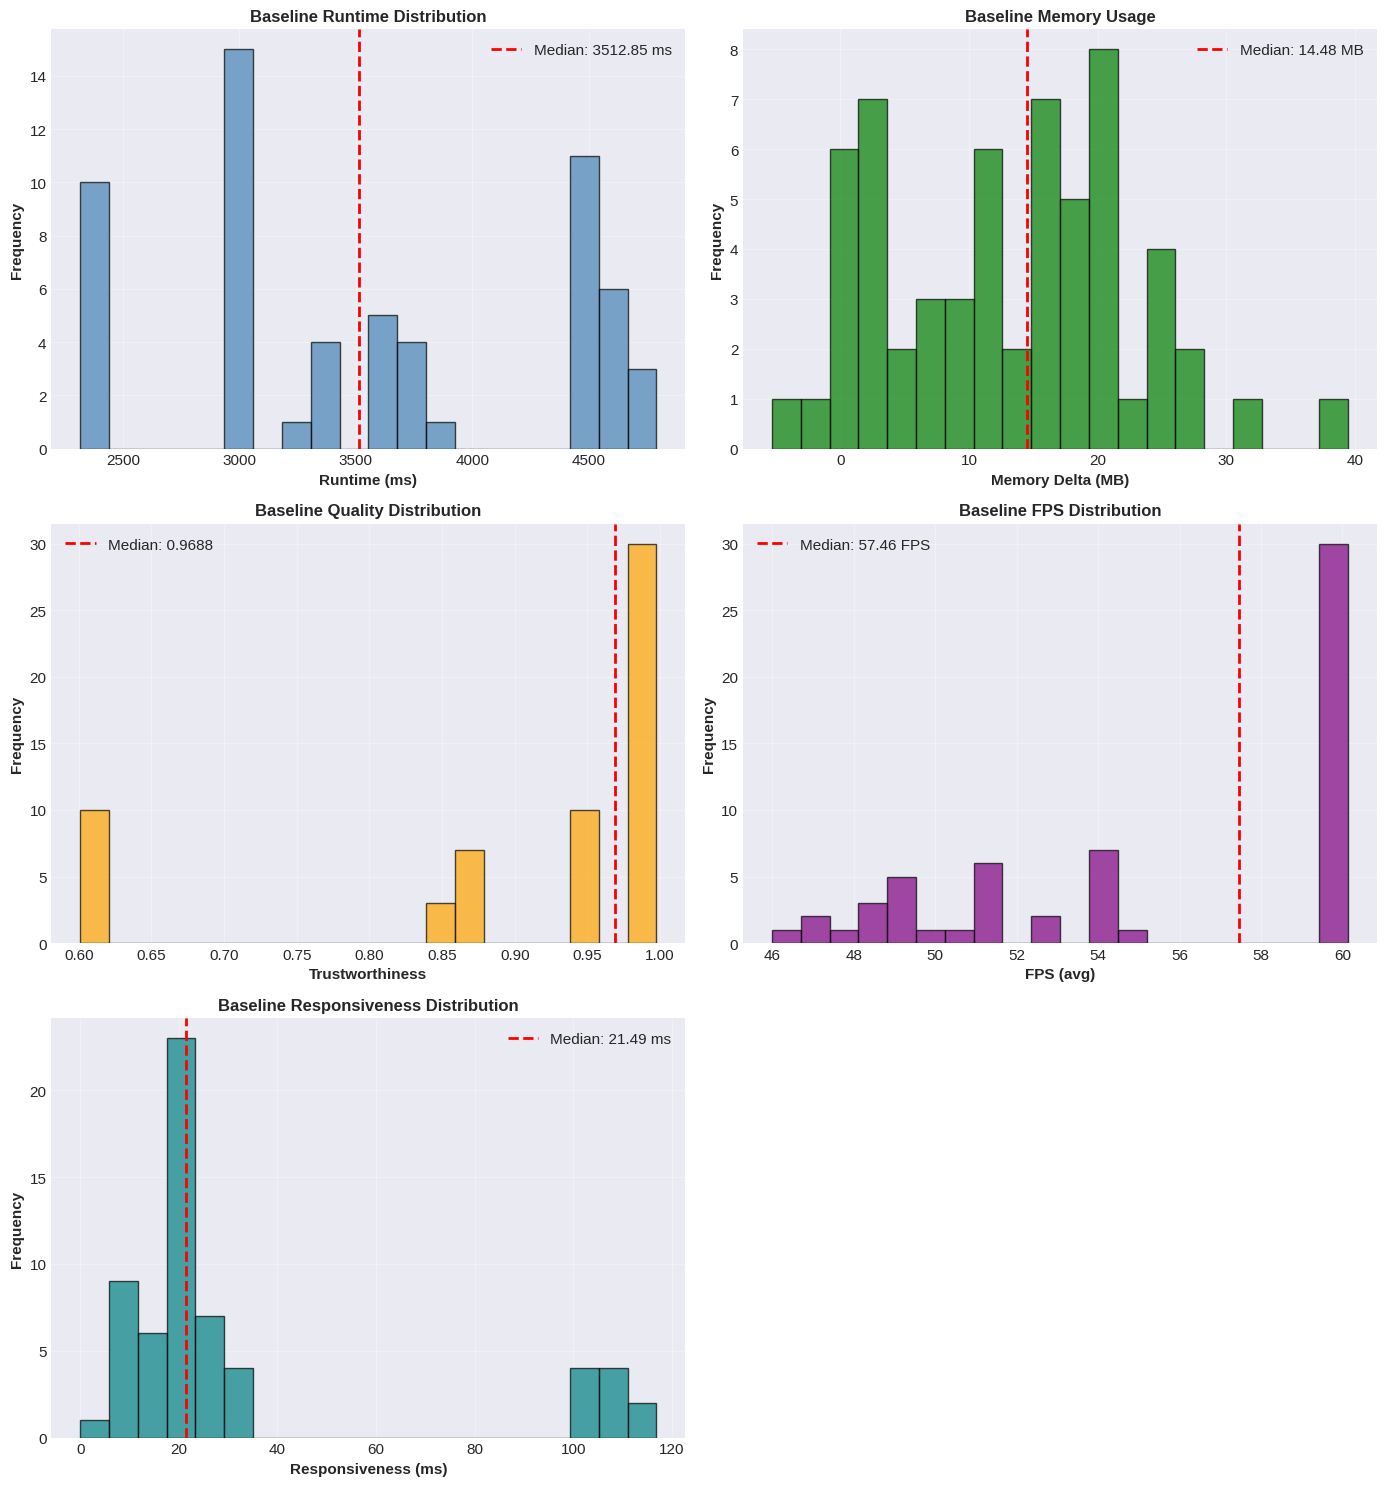

In [140]:
# Visualizations for Baseline
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# Runtime distribution
axes[0, 0].hist(baseline_df['runtime_ms'], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].axvline(baseline_df['runtime_ms'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {baseline_df["runtime_ms"].median():.2f} ms')
axes[0, 0].set_xlabel('Runtime (ms)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Baseline Runtime Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Memory usage
axes[0, 1].hist(baseline_df['memory_delta_mb'], bins=20, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].axvline(baseline_df['memory_delta_mb'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {baseline_df["memory_delta_mb"].median():.2f} MB')
axes[0, 1].set_xlabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Baseline Memory Usage', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Quality (Trustworthiness)
axes[1, 0].hist(baseline_df['trustworthiness'], bins=20, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].axvline(baseline_df['trustworthiness'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {baseline_df["trustworthiness"].median():.4f}')
axes[1, 0].set_xlabel('Trustworthiness', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Baseline Quality Distribution', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# FPS
axes[1, 1].hist(baseline_df['fps_avg'], bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(baseline_df['fps_avg'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {baseline_df["fps_avg"].median():.2f} FPS')
axes[1, 1].set_xlabel('FPS (avg)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Baseline FPS Distribution', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# Responsiveness
axes[2, 0].hist(baseline_df['responsiveness_ms'], bins=20, alpha=0.7, color='teal', edgecolor='black')
axes[2, 0].axvline(baseline_df['responsiveness_ms'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {baseline_df["responsiveness_ms"].median():.2f} ms')
axes[2, 0].set_xlabel('Responsiveness (ms)', fontsize=11, fontweight='bold')
axes[2, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[2, 0].set_title('Baseline Responsiveness Distribution', fontsize=12, fontweight='bold')
axes[2, 0].legend()
axes[2, 0].grid(alpha=0.3)

# Hide unused subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.savefig('../outputs/figures/baseline_metrics.png', bbox_inches='tight')
plt.show()


### 4.2 Distance Feature (WASM)

Performance metrics for WASM-accelerated distance calculations.

In [141]:
# Filter data for Distance feature
dist_df = df_analysis[df_analysis['feature_name'] == 'Distance'].copy()

print(f"{'='*80}")
print(f"WASM FEATURE: Distance")
print(f"{'='*80}")
print(f"Total measurements: {len(dist_df)}")
print(f"Datasets covered: {dist_df['dataset_name'].nunique()}")
if len(dist_df) > 0:
    print(f"Dataset names: {', '.join(sorted(dist_df['dataset_name'].unique()))}")

    # Runtime Metrics
    print(f"\n{' Runtime (ms) ':=^80}")
    runtime_stats = dist_df['runtime_ms'].describe()
    print(f"  Count:   {runtime_stats['count']:.0f}")
    print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
    print(f"  Median:  {dist_df['runtime_ms'].median():.2f} ms")
    print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
    print(f"  Min:     {runtime_stats['min']:.2f} ms")
    print(f"  Max:     {runtime_stats['max']:.2f} ms")
    print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
    print(f"  75th %:  {runtime_stats['75%']:.2f} ms")
    
    # Comparison to Baseline
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        dist_median = dist_df['runtime_ms'].median()
        speedup = baseline_median / dist_median
        pct_change = ((dist_median - baseline_median) / baseline_median) * 100
        print(f"\n  vs Baseline: {speedup:.2f}x speedup ({pct_change:+.1f}%)")

    # Memory Usage
    print(f"\n{' Memory Usage (MB) ':=^80}")
    memory_stats = dist_df['memory_delta_mb'].describe()
    print(f"  Count:   {memory_stats['count']:.0f}")
    print(f"  Mean:    {memory_stats['mean']:.2f} MB")
    print(f"  Median:  {dist_df['memory_delta_mb'].median():.2f} MB")
    print(f"  Std Dev: {memory_stats['std']:.2f} MB")
    print(f"  Min:     {memory_stats['min']:.2f} MB")
    print(f"  Max:     {memory_stats['max']:.2f} MB")

    # Embedding Quality
    print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
    quality_stats = dist_df['trustworthiness'].describe()
    print(f"  Count:   {quality_stats['count']:.0f}")
    print(f"  Mean:    {quality_stats['mean']:.4f}")
    print(f"  Median:  {dist_df['trustworthiness'].median():.4f}")
    print(f"  Std Dev: {quality_stats['std']:.4f}")
    print(f"  Min:     {quality_stats['min']:.4f}")
    print(f"  Max:     {quality_stats['max']:.4f}")

    # Visualization FPS
    print(f"\n{' Visualization FPS ':=^80}")
    fps_stats = dist_df['fps_avg'].describe()
    print(f"  Count:   {fps_stats['count']:.0f}")
    print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
    print(f"  Median:  {dist_df['fps_avg'].median():.2f} FPS")
    print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
    print(f"  Min:     {fps_stats['min']:.2f} FPS")
    print(f"  Max:     {fps_stats['max']:.2f} FPS")

    # Responsiveness
    print(f"\n{' Responsiveness (ms) ':=^80}")
    resp_stats = dist_df['responsiveness_ms'].describe()
    print(f"  Count:   {resp_stats['count']:.0f}")
    print(f"  Mean:    {resp_stats['mean']:.2f} ms")
    print(f"  Median:  {dist_df['responsiveness_ms'].median():.2f} ms")
    print(f"  Std Dev: {resp_stats['std']:.2f} ms")
    print(f"  Min:     {resp_stats['min']:.2f} ms")
    print(f"  Max:     {resp_stats['max']:.2f} ms")

    # Per-Dataset Summary
    print(f"\n{' Per-Dataset Summary ':=^80}")
    dataset_summary = dist_df.groupby('dataset_name').agg({
        'runtime_ms': ['count', 'median', 'mean', 'std'],
        'memory_delta_mb': ['median', 'mean'],
        'trustworthiness': ['median', 'mean'],
        'fps_avg': ['median', 'mean'],
        'responsiveness_ms': ['median', 'mean']
    }).round(3)
    display(dataset_summary)
else:
    print("\n⚠️  No data available for Distance feature")

WASM FEATURE: Distance
Total measurements: 60
Datasets covered: 6
Dataset names: 3D Dense Clusters (1K points), Iris Dataset (150 points, 4D), MNIST-like (1K points, 784D), Medium Clustered (600 points), Small Random (80 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   60
  Mean:    3610.20 ms
  Median:  3504.15 ms
  Std Dev: 871.61 ms
  Min:     2345.60 ms
  Max:     5896.30 ms
  25th %:  2959.25 ms
  75th %:  4533.58 ms

  vs Baseline: 1.00x speedup (-0.2%)

============================== Memory Usage (MB) ===============================
  Count:   60
  Mean:    11.69 MB
  Median:  12.28 MB
  Std Dev: 9.50 MB
  Min:     -8.78 MB
  Max:     42.08 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   60
  Mean:    0.9012
  Median:  0.9691
  Std Dev: 0.1394
  Min:     0.6019
  Max:     0.9974

============================== Visualization FPS ===============

runtime_ms                            memory_delta_mb         trustworthiness  \
                                          count   median     mean      std          median    mean          median   
dataset_name                                                                                                         
3D Dense Clusters (1K points)                10  4554.85  4668.29  435.242           6.530   7.367           0.997   
Iris Dataset (150 points, 4D)                10  2373.80  2377.94   29.087           1.606   2.666           0.989   
MNIST-like (1K points, 784D)                 10  4570.85  4658.86  299.447          17.914  18.603           0.609   
Medium Clustered (600 points)                10  3645.65  3653.02   41.779          19.168  17.137           0.950   
Small Random (80 points)                     10  3327.15  3320.67   94.022           4.831   6.018           0.869   
Swiss Roll (600 points, 3D manifold)         10  2955.50  2982.45   60.442          18.432  18.376           0.994   

                                            fps_avg         responsiveness_ms           
                                       mean  median    mean            median     mean  
dataset_name                                                                            
3D Dense Clusters (1K points)         0.997  50.098  49.116            30.147   30.290  
Iris Dataset (150 points, 4D)         0.988  59.993  59.994             8.577    8.981  
MNIST-like (1K points, 784D)          0.609  60.005  60.010           109.227  110.454  
Medium Clustered (600 points)         0.950  53.951  53.719            21.230   21.541  
Small Random (80 points)              0.869  47.990  48.055            21.570   21.708  
Swiss Roll (600 points, 3D manifold)  0.994  60.010  60.009            18.145   17.939

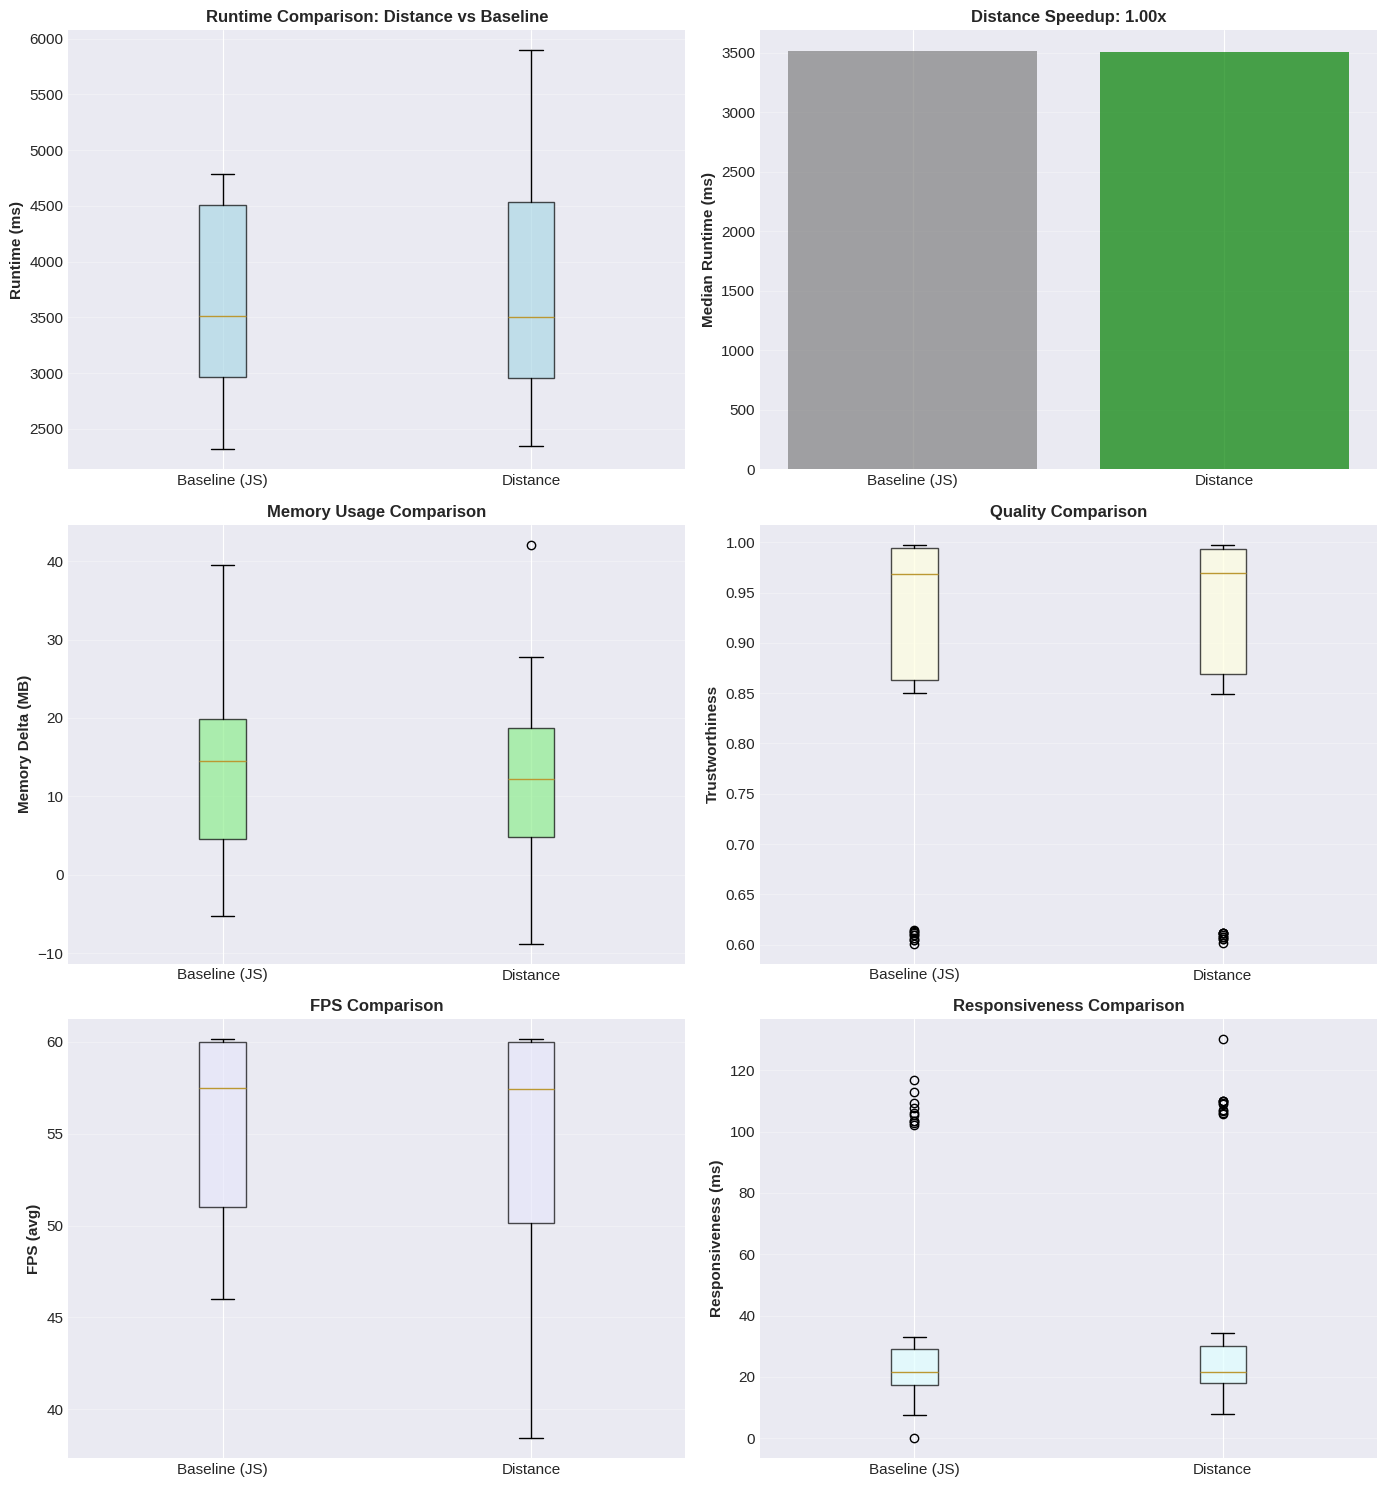

In [142]:
# Visualizations for Distance Feature
if len(dist_df) > 0:
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))
    
    # Runtime comparison
    comparison_data = pd.DataFrame({
        'Baseline (JS)': baseline_df['runtime_ms'],
        'Distance': dist_df['runtime_ms']
    })
    axes[0, 0].boxplot([baseline_df['runtime_ms'], dist_df['runtime_ms']], 
                       labels=['Baseline (JS)', 'Distance'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Runtime Comparison: Distance vs Baseline', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Speedup visualization
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        dist_median = dist_df['runtime_ms'].median()
        speedup = baseline_median / dist_median
        
        axes[0, 1].bar(['Baseline (JS)', 'Distance'], 
                      [baseline_median, dist_median],
                      color=['gray', 'green' if speedup > 1 else 'red'],
                      alpha=0.7)
        axes[0, 1].set_ylabel('Median Runtime (ms)', fontsize=11, fontweight='bold')
        axes[0, 1].set_title(f'Distance Speedup: {speedup:.2f}x', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Memory comparison
    axes[1, 0].boxplot([baseline_df['memory_delta_mb'], dist_df['memory_delta_mb']], 
                       labels=['Baseline (JS)', 'Distance'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1, 0].set_ylabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Memory Usage Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Quality comparison
    axes[1, 1].boxplot([baseline_df['trustworthiness'], dist_df['trustworthiness']], 
                       labels=['Baseline (JS)', 'Distance'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightyellow', alpha=0.7))
    axes[1, 1].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Quality Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # FPS comparison
    axes[2, 0].boxplot([baseline_df['fps_avg'], dist_df['fps_avg']], 
                       labels=['Baseline (JS)', 'Distance'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lavender', alpha=0.7))
    axes[2, 0].set_ylabel('FPS (avg)', fontsize=11, fontweight='bold')
    axes[2, 0].set_title('FPS Comparison', fontsize=12, fontweight='bold')
    axes[2, 0].grid(axis='y', alpha=0.3)
    
    # Responsiveness comparison
    axes[2, 1].boxplot([baseline_df['responsiveness_ms'], dist_df['responsiveness_ms']], 
                       labels=['Baseline (JS)', 'Distance'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightcyan', alpha=0.7))
    axes[2, 1].set_ylabel('Responsiveness (ms)', fontsize=11, fontweight='bold')
    axes[2, 1].set_title('Responsiveness Comparison', fontsize=12, fontweight='bold')
    axes[2, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/distance_comparison.png', bbox_inches='tight')
    plt.show()
else:
    print("No visualizations available (insufficient data)")


### 4.3 Tree Feature (WASM)

Performance metrics for WASM-accelerated tree operations.

In [143]:
# Filter data for Tree feature
tree_df = df_analysis[df_analysis['feature_name'] == 'Tree'].copy()

print(f"{'='*80}")
print(f"WASM FEATURE: Tree")
print(f"{'='*80}")
print(f"Total measurements: {len(tree_df)}")
print(f"Datasets covered: {tree_df['dataset_name'].nunique()}")
if len(tree_df) > 0:
    print(f"Dataset names: {', '.join(sorted(tree_df['dataset_name'].unique()))}")

    # Runtime Metrics
    print(f"\n{' Runtime (ms) ':=^80}")
    runtime_stats = tree_df['runtime_ms'].describe()
    print(f"  Count:   {runtime_stats['count']:.0f}")
    print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
    print(f"  Median:  {tree_df['runtime_ms'].median():.2f} ms")
    print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
    print(f"  Min:     {runtime_stats['min']:.2f} ms")
    print(f"  Max:     {runtime_stats['max']:.2f} ms")
    print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
    print(f"  75th %:  {runtime_stats['75%']:.2f} ms")
    
    # Comparison to Baseline
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        tree_median = tree_df['runtime_ms'].median()
        speedup = baseline_median / tree_median
        pct_change = ((tree_median - baseline_median) / baseline_median) * 100
        print(f"\n  vs Baseline: {speedup:.2f}x speedup ({pct_change:+.1f}%)")

    # Memory Usage
    print(f"\n{' Memory Usage (MB) ':=^80}")
    memory_stats = tree_df['memory_delta_mb'].describe()
    print(f"  Count:   {memory_stats['count']:.0f}")
    print(f"  Mean:    {memory_stats['mean']:.2f} MB")
    print(f"  Median:  {tree_df['memory_delta_mb'].median():.2f} MB")
    print(f"  Std Dev: {memory_stats['std']:.2f} MB")
    print(f"  Min:     {memory_stats['min']:.2f} MB")
    print(f"  Max:     {memory_stats['max']:.2f} MB")

    # Embedding Quality
    print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
    quality_stats = tree_df['trustworthiness'].describe()
    print(f"  Count:   {quality_stats['count']:.0f}")
    print(f"  Mean:    {quality_stats['mean']:.4f}")
    print(f"  Median:  {tree_df['trustworthiness'].median():.4f}")
    print(f"  Std Dev: {quality_stats['std']:.4f}")
    print(f"  Min:     {quality_stats['min']:.4f}")
    print(f"  Max:     {quality_stats['max']:.4f}")

    # Visualization FPS
    print(f"\n{' Visualization FPS ':=^80}")
    fps_stats = tree_df['fps_avg'].describe()
    print(f"  Count:   {fps_stats['count']:.0f}")
    print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
    print(f"  Median:  {tree_df['fps_avg'].median():.2f} FPS")
    print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
    print(f"  Min:     {fps_stats['min']:.2f} FPS")
    print(f"  Max:     {fps_stats['max']:.2f} FPS")

    # Responsiveness
    print(f"\n{' Responsiveness (ms) ':=^80}")
    resp_stats = tree_df['responsiveness_ms'].describe()
    print(f"  Count:   {resp_stats['count']:.0f}")
    print(f"  Mean:    {resp_stats['mean']:.2f} ms")
    print(f"  Median:  {tree_df['responsiveness_ms'].median():.2f} ms")
    print(f"  Std Dev: {resp_stats['std']:.2f} ms")
    print(f"  Min:     {resp_stats['min']:.2f} ms")
    print(f"  Max:     {resp_stats['max']:.2f} ms")

    # Per-Dataset Summary
    print(f"\n{' Per-Dataset Summary ':=^80}")
    dataset_summary = tree_df.groupby('dataset_name').agg({
        'runtime_ms': ['count', 'median', 'mean', 'std'],
        'memory_delta_mb': ['median', 'mean'],
        'trustworthiness': ['median', 'mean'],
        'fps_avg': ['median', 'mean'],
        'responsiveness_ms': ['median', 'mean']
    }).round(3)
    display(dataset_summary)
else:
    print("\n⚠️  No data available for Tree feature")

WASM FEATURE: Tree
Total measurements: 60
Datasets covered: 6
Dataset names: 3D Dense Clusters (1K points), Iris Dataset (150 points, 4D), MNIST-like (1K points, 784D), Medium Clustered (600 points), Small Random (80 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   60
  Mean:    3496.44 ms
  Median:  3478.60 ms
  Std Dev: 788.29 ms
  Min:     2314.50 ms
  Max:     4722.80 ms
  25th %:  2956.05 ms
  75th %:  4309.85 ms

  vs Baseline: 1.01x speedup (-1.0%)

============================== Memory Usage (MB) ===============================
  Count:   60
  Mean:    14.37 MB
  Median:  9.78 MB
  Std Dev: 15.58 MB
  Min:     -18.60 MB
  Max:     60.22 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   60
  Mean:    0.9009
  Median:  0.9701
  Std Dev: 0.1389
  Min:     0.6061
  Max:     0.9974

============================== Visualization FPS ==================

runtime_ms                            memory_delta_mb         trustworthiness  \
                                          count   median     mean      std          median    mean          median   
dataset_name                                                                                                         
3D Dense Clusters (1K points)                10  4480.95  4449.43  131.604           2.998   1.073           0.997   
Iris Dataset (150 points, 4D)                10  2352.90  2354.02   24.418           3.118   3.414           0.989   
MNIST-like (1K points, 784D)                 10  4360.15  4414.99  150.434          42.822  41.705           0.611   
Medium Clustered (600 points)                10  3672.35  3727.52  196.839          11.141  13.481           0.951   
Small Random (80 points)                     10  2994.05  3046.78  145.747           7.387   7.091           0.863   
Swiss Roll (600 points, 3D manifold)         10  2970.05  2985.89   52.217          19.249  19.449           0.994   

                                            fps_avg         responsiveness_ms          
                                       mean  median    mean            median    mean  
dataset_name                                                                           
3D Dense Clusters (1K points)         0.997  51.033  50.578            29.157  29.809  
Iris Dataset (150 points, 4D)         0.989  60.000  60.000             8.068   7.377  
MNIST-like (1K points, 784D)          0.611  59.978  59.991           100.250  99.308  
Medium Clustered (600 points)         0.951  53.995  53.837            21.790  22.672  
Small Random (80 points)              0.864  47.601  47.358            20.017  19.911  
Swiss Roll (600 points, 3D manifold)  0.994  60.005  60.015            17.468  17.510

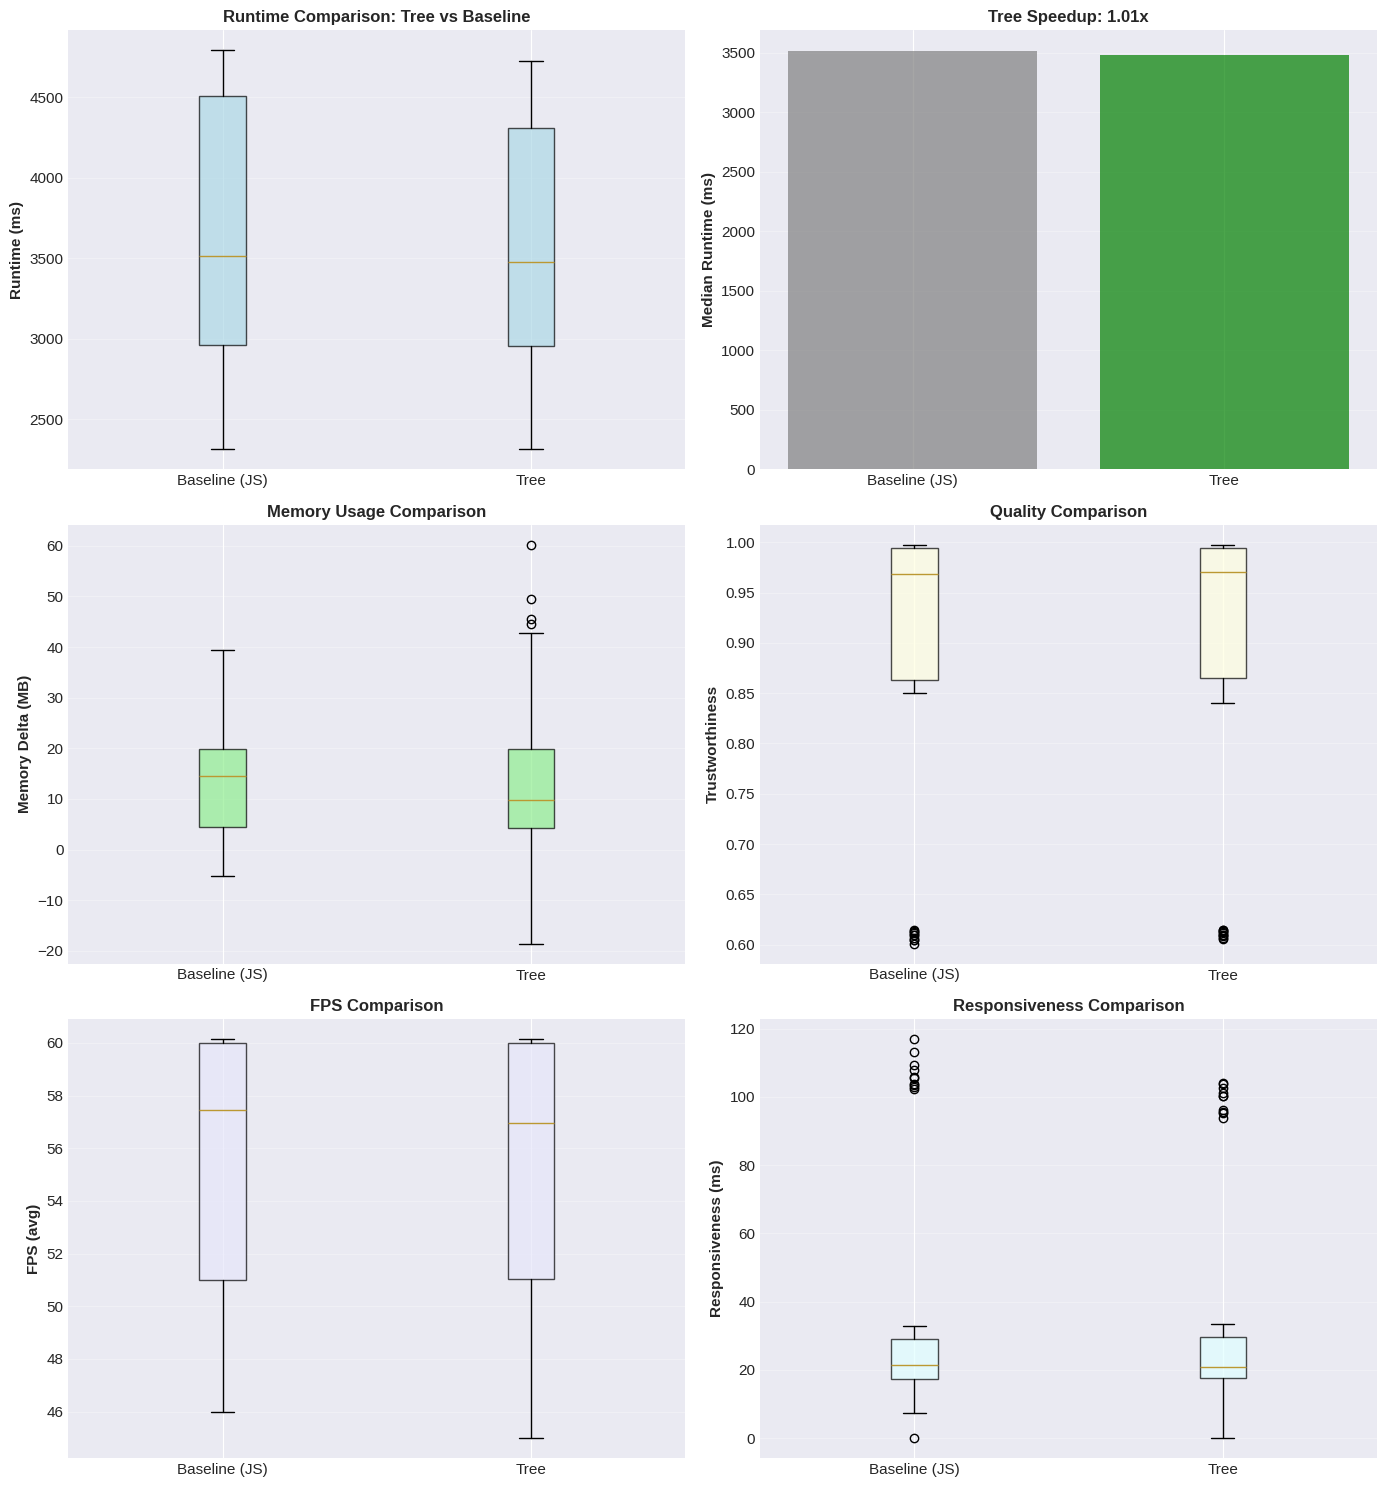

In [144]:
# Visualizations for Tree Feature
if len(tree_df) > 0:
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))
    
    # Runtime comparison
    axes[0, 0].boxplot([baseline_df['runtime_ms'], tree_df['runtime_ms']], 
                       labels=['Baseline (JS)', 'Tree'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Runtime Comparison: Tree vs Baseline', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Speedup visualization
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        tree_median = tree_df['runtime_ms'].median()
        speedup = baseline_median / tree_median
        
        axes[0, 1].bar(['Baseline (JS)', 'Tree'], 
                      [baseline_median, tree_median],
                      color=['gray', 'green' if speedup > 1 else 'red'],
                      alpha=0.7)
        axes[0, 1].set_ylabel('Median Runtime (ms)', fontsize=11, fontweight='bold')
        axes[0, 1].set_title(f'Tree Speedup: {speedup:.2f}x', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Memory comparison
    axes[1, 0].boxplot([baseline_df['memory_delta_mb'], tree_df['memory_delta_mb']], 
                       labels=['Baseline (JS)', 'Tree'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1, 0].set_ylabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Memory Usage Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Quality comparison
    axes[1, 1].boxplot([baseline_df['trustworthiness'], tree_df['trustworthiness']], 
                       labels=['Baseline (JS)', 'Tree'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightyellow', alpha=0.7))
    axes[1, 1].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Quality Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # FPS comparison
    axes[2, 0].boxplot([baseline_df['fps_avg'], tree_df['fps_avg']], 
                       labels=['Baseline (JS)', 'Tree'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lavender', alpha=0.7))
    axes[2, 0].set_ylabel('FPS (avg)', fontsize=11, fontweight='bold')
    axes[2, 0].set_title('FPS Comparison', fontsize=12, fontweight='bold')
    axes[2, 0].grid(axis='y', alpha=0.3)
    
    # Responsiveness comparison
    axes[2, 1].boxplot([baseline_df['responsiveness_ms'], tree_df['responsiveness_ms']], 
                       labels=['Baseline (JS)', 'Tree'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightcyan', alpha=0.7))
    axes[2, 1].set_ylabel('Responsiveness (ms)', fontsize=11, fontweight='bold')
    axes[2, 1].set_title('Responsiveness Comparison', fontsize=12, fontweight='bold')
    axes[2, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/tree_comparison.png', bbox_inches='tight')
    plt.show()
else:
    print("No visualizations available (insufficient data)")


### 4.4 Matrix Feature (WASM)

Performance metrics for WASM-accelerated matrix operations.

In [145]:
# Filter data for NN Descent feature
nn_df = df_analysis[df_analysis['feature_name'] == 'NN Descent'].copy()

print(f"{'='*80}")
print(f"WASM FEATURE: NN Descent")
print(f"{'='*80}")
print(f"Total measurements: {len(nn_df)}")
print(f"Datasets covered: {nn_df['dataset_name'].nunique()}")
if len(nn_df) > 0:
    print(f"Dataset names: {', '.join(sorted(nn_df['dataset_name'].unique()))}")

    # Runtime Metrics
    print(f"\n{' Runtime (ms) ':=^80}")
    runtime_stats = nn_df['runtime_ms'].describe()
    print(f"  Count:   {runtime_stats['count']:.0f}")
    print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
    print(f"  Median:  {nn_df['runtime_ms'].median():.2f} ms")
    print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
    print(f"  Min:     {runtime_stats['min']:.2f} ms")
    print(f"  Max:     {runtime_stats['max']:.2f} ms")
    print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
    print(f"  75th %:  {runtime_stats['75%']:.2f} ms")
    
    # Comparison to Baseline
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        nn_median = nn_df['runtime_ms'].median()
        speedup = baseline_median / nn_median
        pct_change = ((nn_median - baseline_median) / baseline_median) * 100
        print(f"\n  vs Baseline: {speedup:.2f}x speedup ({pct_change:+.1f}%)")

    # Memory Usage
    print(f"\n{' Memory Usage (MB) ':=^80}")
    memory_stats = nn_df['memory_delta_mb'].describe()
    print(f"  Count:   {memory_stats['count']:.0f}")
    print(f"  Mean:    {memory_stats['mean']:.2f} MB")
    print(f"  Median:  {nn_df['memory_delta_mb'].median():.2f} MB")
    print(f"  Std Dev: {memory_stats['std']:.2f} MB")
    print(f"  Min:     {memory_stats['min']:.2f} MB")
    print(f"  Max:     {memory_stats['max']:.2f} MB")

    # Embedding Quality
    print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
    quality_stats = nn_df['trustworthiness'].describe()
    print(f"  Count:   {quality_stats['count']:.0f}")
    print(f"  Mean:    {quality_stats['mean']:.4f}")
    print(f"  Median:  {nn_df['trustworthiness'].median():.4f}")
    print(f"  Std Dev: {quality_stats['std']:.4f}")
    print(f"  Min:     {quality_stats['min']:.4f}")
    print(f"  Max:     {quality_stats['max']:.4f}")

    # Visualization FPS
    print(f"\n{' Visualization FPS ':=^80}")
    fps_stats = nn_df['fps_avg'].describe()
    print(f"  Count:   {fps_stats['count']:.0f}")
    print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
    print(f"  Median:  {nn_df['fps_avg'].median():.2f} FPS")
    print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
    print(f"  Min:     {fps_stats['min']:.2f} FPS")
    print(f"  Max:     {fps_stats['max']:.2f} FPS")

    # Responsiveness
    print(f"\n{' Responsiveness (ms) ':=^80}")
    resp_stats = nn_df['responsiveness_ms'].describe()
    print(f"  Count:   {resp_stats['count']:.0f}")
    print(f"  Mean:    {resp_stats['mean']:.2f} ms")
    print(f"  Median:  {nn_df['responsiveness_ms'].median():.2f} ms")
    print(f"  Std Dev: {resp_stats['std']:.2f} ms")
    print(f"  Min:     {resp_stats['min']:.2f} ms")
    print(f"  Max:     {resp_stats['max']:.2f} ms")

    # Per-Dataset Summary
    print(f"\n{' Per-Dataset Summary ':=^80}")
    dataset_summary = nn_df.groupby('dataset_name').agg({
        'runtime_ms': ['count', 'median', 'mean', 'std'],
        'memory_delta_mb': ['median', 'mean'],
        'trustworthiness': ['median', 'mean'],
        'fps_avg': ['median', 'mean'],
        'responsiveness_ms': ['median', 'mean']
    }).round(3)
    display(dataset_summary)
else:
    print("\n⚠️  No data available for NN Descent feature")

WASM FEATURE: NN Descent
Total measurements: 60
Datasets covered: 6
Dataset names: 3D Dense Clusters (1K points), Iris Dataset (150 points, 4D), MNIST-like (1K points, 784D), Medium Clustered (600 points), Small Random (80 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   60
  Mean:    3603.92 ms
  Median:  3489.85 ms
  Std Dev: 844.06 ms
  Min:     2366.20 ms
  Max:     5295.80 ms
  25th %:  2959.63 ms
  75th %:  4530.22 ms

  vs Baseline: 1.01x speedup (-0.7%)

============================== Memory Usage (MB) ===============================
  Count:   60
  Mean:    17.98 MB
  Median:  16.87 MB
  Std Dev: 11.25 MB
  Min:     -8.42 MB
  Max:     47.45 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   60
  Mean:    0.8988
  Median:  0.9698
  Std Dev: 0.1419
  Min:     0.5986
  Max:     0.9973

============================== Visualization FPS ============

runtime_ms                            memory_delta_mb         trustworthiness  \
                                          count   median     mean      std          median    mean          median   
dataset_name                                                                                                         
3D Dense Clusters (1K points)                10  4555.40  4630.08  251.914          10.911  11.683           0.997   
Iris Dataset (150 points, 4D)                10  2388.25  2394.89   22.202          10.909  10.727           0.989   
MNIST-like (1K points, 784D)                 10  4639.55  4660.77  174.235          34.130  33.765           0.603   
Medium Clustered (600 points)                10  3623.75  3633.93   41.371          15.388  14.612           0.952   
Small Random (80 points)                     10  3346.00  3343.05   52.036          13.468  12.525           0.859   
Swiss Roll (600 points, 3D manifold)         10  2958.85  2960.80   16.975          25.713  24.582           0.994   

                                            fps_avg         responsiveness_ms           
                                       mean  median    mean            median     mean  
dataset_name                                                                            
3D Dense Clusters (1K points)         0.997  50.234  50.171            28.210   28.188  
Iris Dataset (150 points, 4D)         0.989  59.994  59.993             9.909    9.924  
MNIST-like (1K points, 784D)          0.603  59.966  59.958           112.668  111.508  
Medium Clustered (600 points)         0.952  54.000  53.771            20.280   20.449  
Small Random (80 points)              0.859  48.205  47.943            20.603   21.138  
Swiss Roll (600 points, 3D manifold)  0.994  60.007  60.008            16.809   16.984

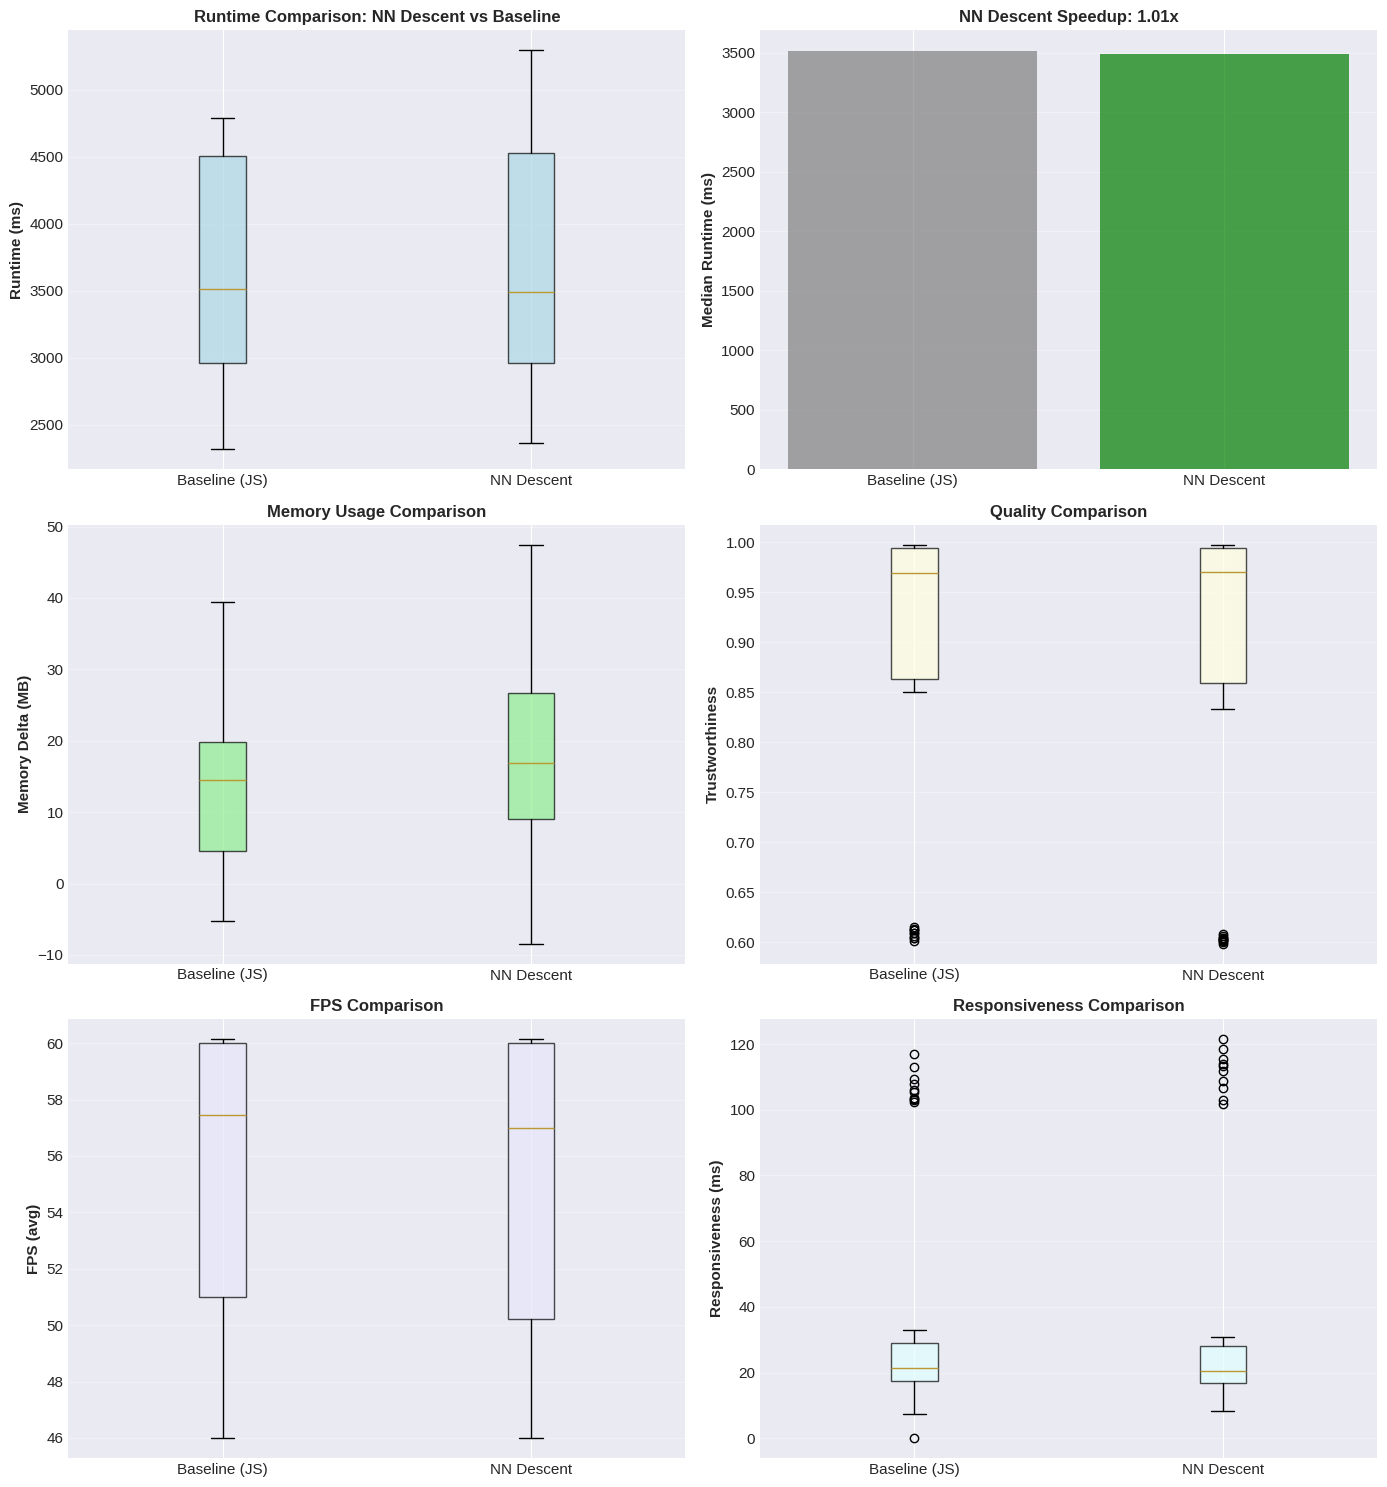

In [146]:
# Visualizations for NN Descent Feature
if len(nn_df) > 0:
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))
    
    # Runtime comparison
    axes[0, 0].boxplot([baseline_df['runtime_ms'], nn_df['runtime_ms']], 
                       labels=['Baseline (JS)', 'NN Descent'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Runtime Comparison: NN Descent vs Baseline', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Speedup visualization
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        nn_median = nn_df['runtime_ms'].median()
        speedup = baseline_median / nn_median
        
        axes[0, 1].bar(['Baseline (JS)', 'NN Descent'], 
                      [baseline_median, nn_median],
                      color=['gray', 'green' if speedup > 1 else 'red'],
                      alpha=0.7)
        axes[0, 1].set_ylabel('Median Runtime (ms)', fontsize=11, fontweight='bold')
        axes[0, 1].set_title(f'NN Descent Speedup: {speedup:.2f}x', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Memory comparison
    axes[1, 0].boxplot([baseline_df['memory_delta_mb'], nn_df['memory_delta_mb']], 
                       labels=['Baseline (JS)', 'NN Descent'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1, 0].set_ylabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Memory Usage Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Quality comparison
    axes[1, 1].boxplot([baseline_df['trustworthiness'], nn_df['trustworthiness']], 
                       labels=['Baseline (JS)', 'NN Descent'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightyellow', alpha=0.7))
    axes[1, 1].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Quality Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # FPS comparison
    axes[2, 0].boxplot([baseline_df['fps_avg'], nn_df['fps_avg']], 
                       labels=['Baseline (JS)', 'NN Descent'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lavender', alpha=0.7))
    axes[2, 0].set_ylabel('FPS (avg)', fontsize=11, fontweight='bold')
    axes[2, 0].set_title('FPS Comparison', fontsize=12, fontweight='bold')
    axes[2, 0].grid(axis='y', alpha=0.3)
    
    # Responsiveness comparison
    axes[2, 1].boxplot([baseline_df['responsiveness_ms'], nn_df['responsiveness_ms']], 
                       labels=['Baseline (JS)', 'NN Descent'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightcyan', alpha=0.7))
    axes[2, 1].set_ylabel('Responsiveness (ms)', fontsize=11, fontweight='bold')
    axes[2, 1].set_title('Responsiveness Comparison', fontsize=12, fontweight='bold')
    axes[2, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/nn_descent_comparison.png', bbox_inches='tight')
    plt.show()
else:
    print("No visualizations available (insufficient data)")


### 4.6 Optimizer Feature (WASM)

Performance metrics for WASM-accelerated optimization.

In [147]:
# Filter data for All Features
all_df = df_analysis[df_analysis['feature_name'] == 'All Features'].copy()

print(f"{'='*80}")
print(f"WASM FEATURE: All Features Combined")
print(f"{'='*80}")
print(f"Total measurements: {len(all_df)}")
print(f"Datasets covered: {all_df['dataset_name'].nunique()}")
if len(all_df) > 0:
    print(f"Dataset names: {', '.join(sorted(all_df['dataset_name'].unique()))}")

    # Runtime Metrics
    print(f"\n{' Runtime (ms) ':=^80}")
    runtime_stats = all_df['runtime_ms'].describe()
    print(f"  Count:   {runtime_stats['count']:.0f}")
    print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
    print(f"  Median:  {all_df['runtime_ms'].median():.2f} ms")
    print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
    print(f"  Min:     {runtime_stats['min']:.2f} ms")
    print(f"  Max:     {runtime_stats['max']:.2f} ms")
    print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
    print(f"  75th %:  {runtime_stats['75%']:.2f} ms")
    
    # Comparison to Baseline
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        all_median = all_df['runtime_ms'].median()
        speedup = baseline_median / all_median
        pct_change = ((all_median - baseline_median) / baseline_median) * 100
        print(f"\n  vs Baseline: {speedup:.2f}x speedup ({pct_change:+.1f}%)")

    # Memory Usage
    print(f"\n{' Memory Usage (MB) ':=^80}")
    memory_stats = all_df['memory_delta_mb'].describe()
    print(f"  Count:   {memory_stats['count']:.0f}")
    print(f"  Mean:    {memory_stats['mean']:.2f} MB")
    print(f"  Median:  {all_df['memory_delta_mb'].median():.2f} MB")
    print(f"  Std Dev: {memory_stats['std']:.2f} MB")
    print(f"  Min:     {memory_stats['min']:.2f} MB")
    print(f"  Max:     {memory_stats['max']:.2f} MB")

    # Embedding Quality
    print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
    quality_stats = all_df['trustworthiness'].describe()
    print(f"  Count:   {quality_stats['count']:.0f}")
    print(f"  Mean:    {quality_stats['mean']:.4f}")
    print(f"  Median:  {all_df['trustworthiness'].median():.4f}")
    print(f"  Std Dev: {quality_stats['std']:.4f}")
    print(f"  Min:     {quality_stats['min']:.4f}")
    print(f"  Max:     {quality_stats['max']:.4f}")

    # Visualization FPS
    print(f"\n{' Visualization FPS ':=^80}")
    fps_stats = all_df['fps_avg'].describe()
    print(f"  Count:   {fps_stats['count']:.0f}")
    print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
    print(f"  Median:  {all_df['fps_avg'].median():.2f} FPS")
    print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
    print(f"  Min:     {fps_stats['min']:.2f} FPS")
    print(f"  Max:     {fps_stats['max']:.2f} FPS")

    # Responsiveness
    print(f"\n{' Responsiveness (ms) ':=^80}")
    resp_stats = all_df['responsiveness_ms'].describe()
    print(f"  Count:   {resp_stats['count']:.0f}")
    print(f"  Mean:    {resp_stats['mean']:.2f} ms")
    print(f"  Median:  {all_df['responsiveness_ms'].median():.2f} ms")
    print(f"  Std Dev: {resp_stats['std']:.2f} ms")
    print(f"  Min:     {resp_stats['min']:.2f} ms")
    print(f"  Max:     {resp_stats['max']:.2f} ms")

    # Per-Dataset Summary
    print(f"\n{' Per-Dataset Summary ':=^80}")
    dataset_summary = all_df.groupby('dataset_name').agg({
        'runtime_ms': ['count', 'median', 'mean', 'std'],
        'memory_delta_mb': ['median', 'mean'],
        'trustworthiness': ['median', 'mean'],
        'fps_avg': ['median', 'mean'],
        'responsiveness_ms': ['median', 'mean']
    }).round(3)
    display(dataset_summary)
else:
    print("\n⚠️  No data available for All Features")

WASM FEATURE: All Features Combined
Total measurements: 40
Datasets covered: 4
Dataset names: 3D Dense Clusters (1K points), MNIST-like (1K points, 784D), Medium Clustered (600 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   40
  Mean:    2716.92 ms
  Median:  2781.80 ms
  Std Dev: 935.67 ms
  Min:     1553.40 ms
  Max:     4111.70 ms
  25th %:  1903.75 ms
  75th %:  3533.33 ms

  vs Baseline: 1.26x speedup (-20.8%)

============================== Memory Usage (MB) ===============================
  Count:   40
  Mean:    13.97 MB
  Median:  16.27 MB
  Std Dev: 12.45 MB
  Min:     -10.35 MB
  Max:     35.88 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   40
  Mean:    0.8776
  Median:  0.9718
  Std Dev: 0.1801
  Min:     0.5648
  Max:     0.9972

============================== Visualization FPS ===============================
  Count:   40
  Mean:   

runtime_ms                            memory_delta_mb         trustworthiness  \
                                          count   median     mean      std          median    mean          median   
dataset_name                                                                                                         
3D Dense Clusters (1K points)                10  3374.05  3383.93   41.205           8.807  10.486           0.997   
MNIST-like (1K points, 784D)                 10  3817.70  3829.81  112.426          28.994  29.164           0.571   
Medium Clustered (600 points)                10  2033.00  2077.87   92.669          -2.823   1.584           0.948   
Swiss Roll (600 points, 3D manifold)         10  1568.10  1576.06   20.255          18.344  14.636           0.994   

                                            fps_avg         responsiveness_ms           
                                       mean  median    mean            median     mean  
dataset_name                                                                            
3D Dense Clusters (1K points)         0.997  36.641  36.912            26.007   26.050  
MNIST-like (1K points, 784D)          0.571  39.639  39.287           103.268  102.425  
Medium Clustered (600 points)         0.948  39.402  41.962            18.030   18.090  
Swiss Roll (600 points, 3D manifold)  0.994  49.201  49.377            14.550   14.368

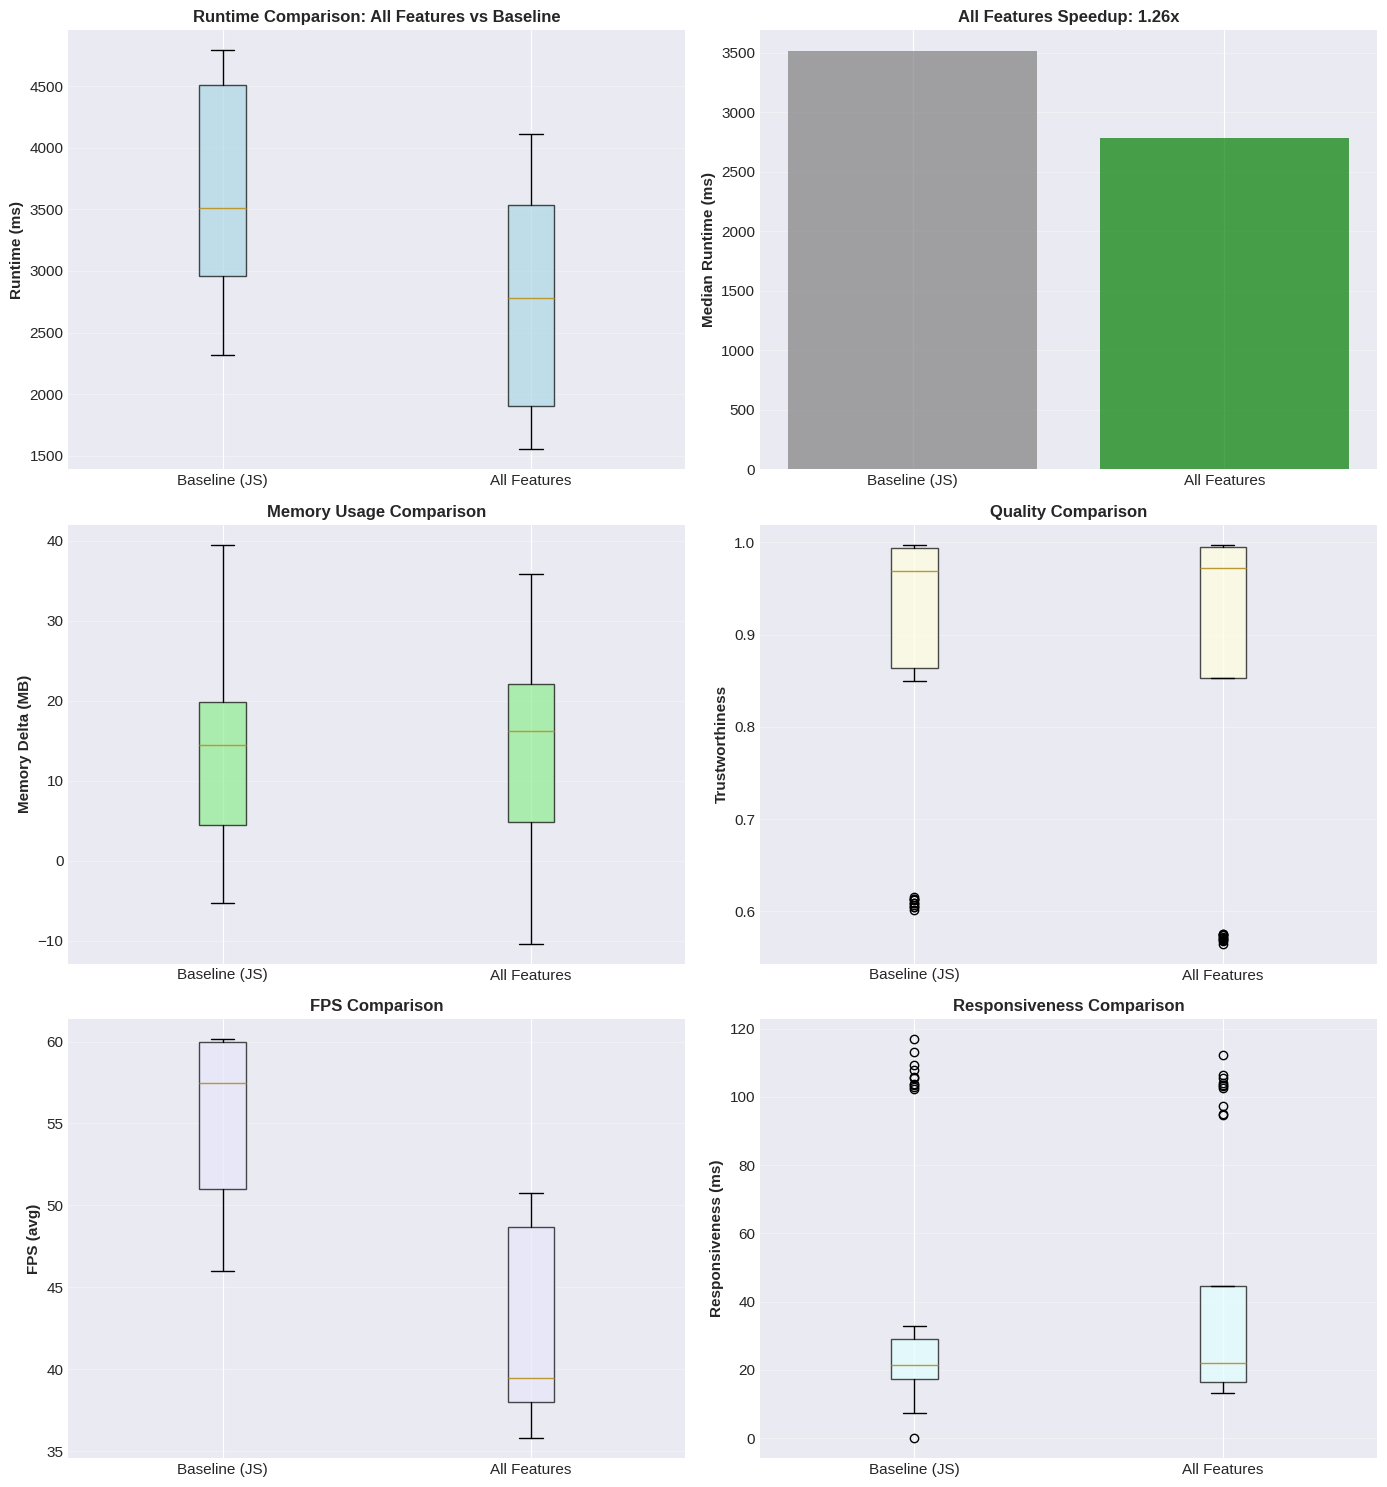

In [148]:
# Visualizations for All Features Combined
if len(all_df) > 0:
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))
    
    # Runtime comparison
    axes[0, 0].boxplot([baseline_df['runtime_ms'], all_df['runtime_ms']], 
                       labels=['Baseline (JS)', 'All Features'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Runtime Comparison: All Features vs Baseline', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Speedup visualization
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        all_median = all_df['runtime_ms'].median()
        speedup = baseline_median / all_median
        
        axes[0, 1].bar(['Baseline (JS)', 'All Features'], 
                      [baseline_median, all_median],
                      color=['gray', 'green' if speedup > 1 else 'red'],
                      alpha=0.7)
        axes[0, 1].set_ylabel('Median Runtime (ms)', fontsize=11, fontweight='bold')
        axes[0, 1].set_title(f'All Features Speedup: {speedup:.2f}x', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Memory comparison
    axes[1, 0].boxplot([baseline_df['memory_delta_mb'], all_df['memory_delta_mb']], 
                       labels=['Baseline (JS)', 'All Features'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1, 0].set_ylabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Memory Usage Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Quality comparison
    axes[1, 1].boxplot([baseline_df['trustworthiness'], all_df['trustworthiness']], 
                       labels=['Baseline (JS)', 'All Features'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightyellow', alpha=0.7))
    axes[1, 1].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Quality Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # FPS comparison
    axes[2, 0].boxplot([baseline_df['fps_avg'], all_df['fps_avg']], 
                       labels=['Baseline (JS)', 'All Features'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lavender', alpha=0.7))
    axes[2, 0].set_ylabel('FPS (avg)', fontsize=11, fontweight='bold')
    axes[2, 0].set_title('FPS Comparison', fontsize=12, fontweight='bold')
    axes[2, 0].grid(axis='y', alpha=0.3)
    
    # Responsiveness comparison
    axes[2, 1].boxplot([baseline_df['responsiveness_ms'], all_df['responsiveness_ms']], 
                       labels=['Baseline (JS)', 'All Features'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightcyan', alpha=0.7))
    axes[2, 1].set_ylabel('Responsiveness (ms)', fontsize=11, fontweight='bold')
    axes[2, 1].set_title('Responsiveness Comparison', fontsize=12, fontweight='bold')
    axes[2, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/all_features_comparison.png', bbox_inches='tight')
    plt.show()
else:
    print("No visualizations available (insufficient data)")


In [149]:
# Filter data for Optimizer feature
opt_df = df_analysis[df_analysis['feature_name'] == 'Optimizer'].copy()

print(f"{'='*80}")
print(f"WASM FEATURE: Optimizer")
print(f"{'='*80}")
print(f"Total measurements: {len(opt_df)}")
print(f"Datasets covered: {opt_df['dataset_name'].nunique()}")
if len(opt_df) > 0:
    print(f"Dataset names: {', '.join(sorted(opt_df['dataset_name'].unique()))}")

    # Runtime Metrics
    print(f"\n{' Runtime (ms) ':=^80}")
    runtime_stats = opt_df['runtime_ms'].describe()
    print(f"  Count:   {runtime_stats['count']:.0f}")
    print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
    print(f"  Median:  {opt_df['runtime_ms'].median():.2f} ms")
    print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
    print(f"  Min:     {runtime_stats['min']:.2f} ms")
    print(f"  Max:     {runtime_stats['max']:.2f} ms")
    print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
    print(f"  75th %:  {runtime_stats['75%']:.2f} ms")
    
    # Comparison to Baseline
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        opt_median = opt_df['runtime_ms'].median()
        speedup = baseline_median / opt_median
        pct_change = ((opt_median - baseline_median) / baseline_median) * 100
        print(f"\n  vs Baseline: {speedup:.2f}x speedup ({pct_change:+.1f}%)")

    # Memory Usage
    print(f"\n{' Memory Usage (MB) ':=^80}")
    memory_stats = opt_df['memory_delta_mb'].describe()
    print(f"  Count:   {memory_stats['count']:.0f}")
    print(f"  Mean:    {memory_stats['mean']:.2f} MB")
    print(f"  Median:  {opt_df['memory_delta_mb'].median():.2f} MB")
    print(f"  Std Dev: {memory_stats['std']:.2f} MB")
    print(f"  Min:     {memory_stats['min']:.2f} MB")
    print(f"  Max:     {memory_stats['max']:.2f} MB")

    # Embedding Quality
    print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
    quality_stats = opt_df['trustworthiness'].describe()
    print(f"  Count:   {quality_stats['count']:.0f}")
    print(f"  Mean:    {quality_stats['mean']:.4f}")
    print(f"  Median:  {opt_df['trustworthiness'].median():.4f}")
    print(f"  Std Dev: {quality_stats['std']:.4f}")
    print(f"  Min:     {quality_stats['min']:.4f}")
    print(f"  Max:     {quality_stats['max']:.4f}")

    # Visualization FPS
    print(f"\n{' Visualization FPS ':=^80}")
    fps_stats = opt_df['fps_avg'].describe()
    print(f"  Count:   {fps_stats['count']:.0f}")
    print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
    print(f"  Median:  {opt_df['fps_avg'].median():.2f} FPS")
    print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
    print(f"  Min:     {fps_stats['min']:.2f} FPS")
    print(f"  Max:     {fps_stats['max']:.2f} FPS")

    # Responsiveness
    print(f"\n{' Responsiveness (ms) ':=^80}")
    resp_stats = opt_df['responsiveness_ms'].describe()
    print(f"  Count:   {resp_stats['count']:.0f}")
    print(f"  Mean:    {resp_stats['mean']:.2f} ms")
    print(f"  Median:  {opt_df['responsiveness_ms'].median():.2f} ms")
    print(f"  Std Dev: {resp_stats['std']:.2f} ms")
    print(f"  Min:     {resp_stats['min']:.2f} ms")
    print(f"  Max:     {resp_stats['max']:.2f} ms")

    # Per-Dataset Summary
    print(f"\n{' Per-Dataset Summary ':=^80}")
    dataset_summary = opt_df.groupby('dataset_name').agg({
        'runtime_ms': ['count', 'median', 'mean', 'std'],
        'memory_delta_mb': ['median', 'mean'],
        'trustworthiness': ['median', 'mean'],
        'fps_avg': ['median', 'mean'],
        'responsiveness_ms': ['median', 'mean']
    }).round(3)
    display(dataset_summary)
else:
    print("\n⚠️  No data available for Optimizer feature")

WASM FEATURE: Optimizer
Total measurements: 40
Datasets covered: 4
Dataset names: 3D Dense Clusters (1K points), MNIST-like (1K points, 784D), Medium Clustered (600 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   40
  Mean:    2772.85 ms
  Median:  2772.75 ms
  Std Dev: 882.16 ms
  Min:     1587.70 ms
  Max:     3966.00 ms
  25th %:  2088.58 ms
  75th %:  3611.50 ms

  vs Baseline: 1.27x speedup (-21.1%)

============================== Memory Usage (MB) ===============================
  Count:   40
  Mean:    10.59 MB
  Median:  9.75 MB
  Std Dev: 7.18 MB
  Min:     -2.80 MB
  Max:     25.21 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   40
  Mean:    0.8757
  Median:  0.9713
  Std Dev: 0.1833
  Min:     0.5576
  Max:     0.9974

============================== Visualization FPS ===============================
  Count:   40
  Mean:    43.09 FPS
  Me

runtime_ms                            memory_delta_mb         trustworthiness  \
                                          count   median     mean      std          median    mean          median   
dataset_name                                                                                                         
3D Dense Clusters (1K points)                10  3457.40  3395.76  213.316           6.172   8.058           0.997   
MNIST-like (1K points, 784D)                 10  3845.45  3786.62  126.726           5.435   4.845           0.565   
Medium Clustered (600 points)                10  2263.20  2281.15   89.212           9.941  12.013           0.948   
Swiss Roll (600 points, 3D manifold)         10  1601.45  1627.86   66.107          15.115  17.457           0.994   

                                            fps_avg         responsiveness_ms           
                                       mean  median    mean            median     mean  
dataset_name                                                                            
3D Dense Clusters (1K points)         0.997  36.909  36.542            30.477   30.521  
MNIST-like (1K points, 784D)          0.564  40.102  40.347           110.509  110.309  
Medium Clustered (600 points)         0.948  49.776  48.467            21.730   21.879  
Swiss Roll (600 points, 3D manifold)  0.994  47.659  47.009            17.609   17.457

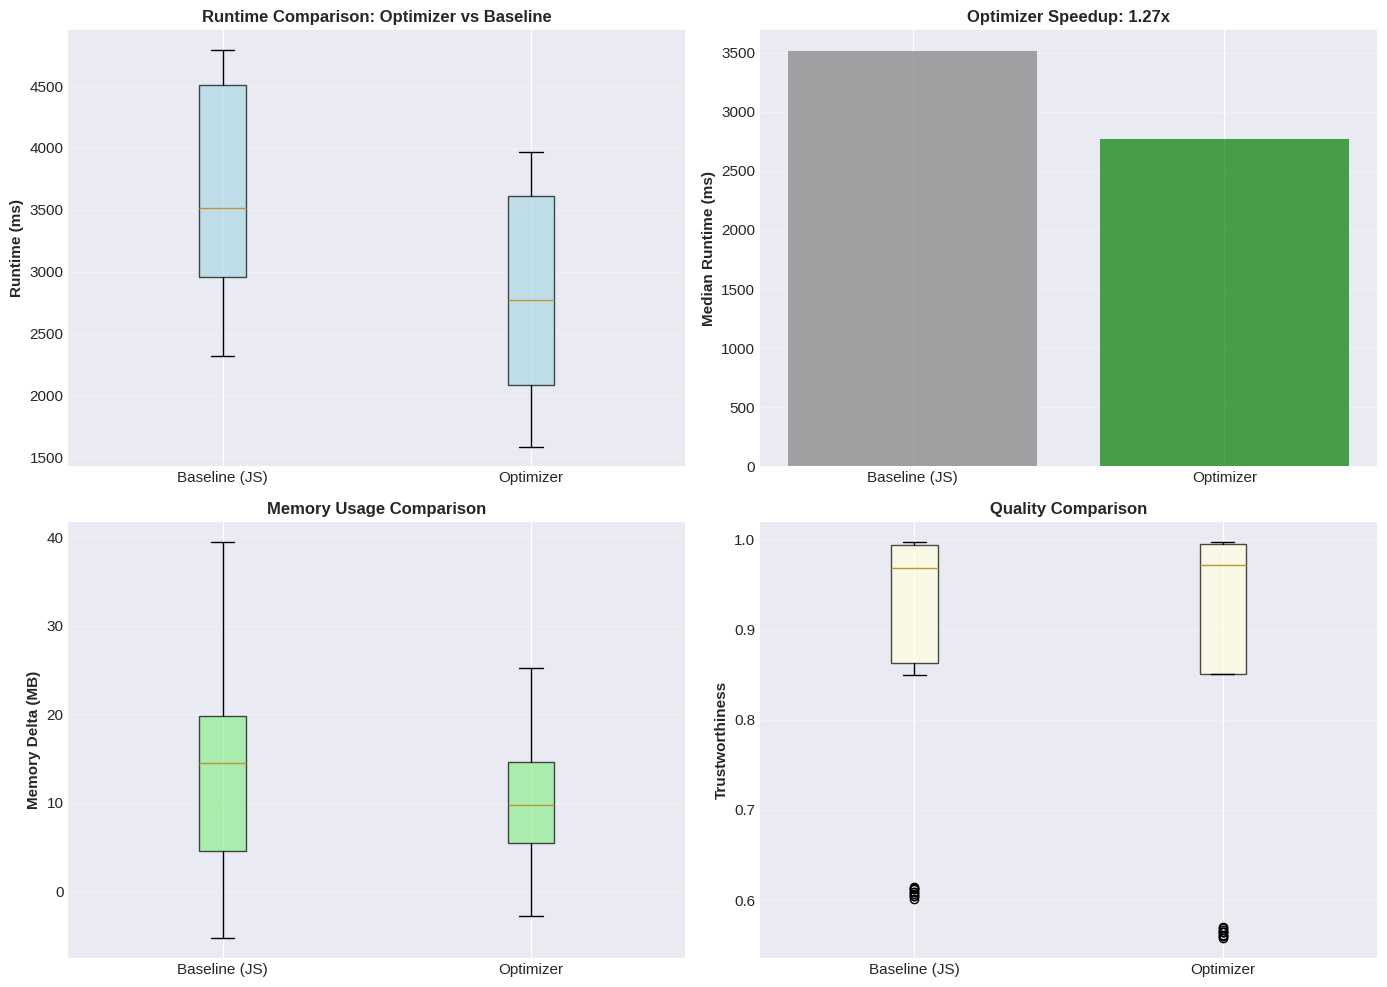

In [150]:
# Visualizations for Optimizer Feature
if len(opt_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Runtime comparison
    axes[0, 0].boxplot([baseline_df['runtime_ms'], opt_df['runtime_ms']], 
                       labels=['Baseline (JS)', 'Optimizer'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Runtime Comparison: Optimizer vs Baseline', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Speedup visualization
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        opt_median = opt_df['runtime_ms'].median()
        speedup = baseline_median / opt_median
        
        axes[0, 1].bar(['Baseline (JS)', 'Optimizer'], 
                      [baseline_median, opt_median],
                      color=['gray', 'green' if speedup > 1 else 'red'],
                      alpha=0.7)
        axes[0, 1].set_ylabel('Median Runtime (ms)', fontsize=11, fontweight='bold')
        axes[0, 1].set_title(f'Optimizer Speedup: {speedup:.2f}x', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Memory comparison
    axes[1, 0].boxplot([baseline_df['memory_delta_mb'], opt_df['memory_delta_mb']], 
                       labels=['Baseline (JS)', 'Optimizer'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1, 0].set_ylabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Memory Usage Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Quality comparison
    axes[1, 1].boxplot([baseline_df['trustworthiness'], opt_df['trustworthiness']], 
                       labels=['Baseline (JS)', 'Optimizer'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightyellow', alpha=0.7))
    axes[1, 1].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Quality Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/optimizer_comparison.png', bbox_inches='tight')
    plt.show()
else:
    print("No visualizations available (insufficient data)")

### 4.7 All Features Combined (WASM)

Performance metrics for all WASM features enabled simultaneously.

In [151]:
# Filter data for Matrix feature
matrix_df = df_analysis[df_analysis['feature_name'] == 'Matrix'].copy()

print(f"{'='*80}")
print(f"WASM FEATURE: Matrix")
print(f"{'='*80}")
print(f"Total measurements: {len(matrix_df)}")
print(f"Datasets covered: {matrix_df['dataset_name'].nunique()}")
if len(matrix_df) > 0:
    print(f"Dataset names: {', '.join(sorted(matrix_df['dataset_name'].unique()))}")

    # Runtime Metrics
    print(f"\n{' Runtime (ms) ':=^80}")
    runtime_stats = matrix_df['runtime_ms'].describe()
    print(f"  Count:   {runtime_stats['count']:.0f}")
    print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
    print(f"  Median:  {matrix_df['runtime_ms'].median():.2f} ms")
    print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
    print(f"  Min:     {runtime_stats['min']:.2f} ms")
    print(f"  Max:     {runtime_stats['max']:.2f} ms")
    print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
    print(f"  75th %:  {runtime_stats['75%']:.2f} ms")
    
    # Comparison to Baseline
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        matrix_median = matrix_df['runtime_ms'].median()
        speedup = baseline_median / matrix_median
        pct_change = ((matrix_median - baseline_median) / baseline_median) * 100
        print(f"\n  vs Baseline: {speedup:.2f}x speedup ({pct_change:+.1f}%)")

    # Memory Usage
    print(f"\n{' Memory Usage (MB) ':=^80}")
    memory_stats = matrix_df['memory_delta_mb'].describe()
    print(f"  Count:   {memory_stats['count']:.0f}")
    print(f"  Mean:    {memory_stats['mean']:.2f} MB")
    print(f"  Median:  {matrix_df['memory_delta_mb'].median():.2f} MB")
    print(f"  Std Dev: {memory_stats['std']:.2f} MB")
    print(f"  Min:     {memory_stats['min']:.2f} MB")
    print(f"  Max:     {memory_stats['max']:.2f} MB")

    # Embedding Quality
    print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
    quality_stats = matrix_df['trustworthiness'].describe()
    print(f"  Count:   {quality_stats['count']:.0f}")
    print(f"  Mean:    {quality_stats['mean']:.4f}")
    print(f"  Median:  {matrix_df['trustworthiness'].median():.4f}")
    print(f"  Std Dev: {quality_stats['std']:.4f}")
    print(f"  Min:     {quality_stats['min']:.4f}")
    print(f"  Max:     {quality_stats['max']:.4f}")

    # Visualization FPS
    print(f"\n{' Visualization FPS ':=^80}")
    fps_stats = matrix_df['fps_avg'].describe()
    print(f"  Count:   {fps_stats['count']:.0f}")
    print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
    print(f"  Median:  {matrix_df['fps_avg'].median():.2f} FPS")
    print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
    print(f"  Min:     {fps_stats['min']:.2f} FPS")
    print(f"  Max:     {fps_stats['max']:.2f} FPS")

    # Responsiveness
    print(f"\n{' Responsiveness (ms) ':=^80}")
    resp_stats = matrix_df['responsiveness_ms'].describe()
    print(f"  Count:   {resp_stats['count']:.0f}")
    print(f"  Mean:    {resp_stats['mean']:.2f} ms")
    print(f"  Median:  {matrix_df['responsiveness_ms'].median():.2f} ms")
    print(f"  Std Dev: {resp_stats['std']:.2f} ms")
    print(f"  Min:     {resp_stats['min']:.2f} ms")
    print(f"  Max:     {resp_stats['max']:.2f} ms")

    # Per-Dataset Summary
    print(f"\n{' Per-Dataset Summary ':=^80}")
    dataset_summary = matrix_df.groupby('dataset_name').agg({
        'runtime_ms': ['count', 'median', 'mean', 'std'],
        'memory_delta_mb': ['median', 'mean'],
        'trustworthiness': ['median', 'mean'],
        'fps_avg': ['median', 'mean'],
        'responsiveness_ms': ['median', 'mean']
    }).round(3)
    display(dataset_summary)
else:
    print("\n⚠️  No data available for Matrix feature")

WASM FEATURE: Matrix
Total measurements: 60
Datasets covered: 6
Dataset names: 3D Dense Clusters (1K points), Iris Dataset (150 points, 4D), MNIST-like (1K points, 784D), Medium Clustered (600 points), Small Random (80 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   60
  Mean:    3501.41 ms
  Median:  3415.65 ms
  Std Dev: 811.15 ms
  Min:     2312.30 ms
  Max:     4788.40 ms
  25th %:  2928.30 ms
  75th %:  4364.98 ms

  vs Baseline: 1.03x speedup (-2.8%)

============================== Memory Usage (MB) ===============================
  Count:   60
  Mean:    11.78 MB
  Median:  10.72 MB
  Std Dev: 10.64 MB
  Min:     -17.46 MB
  Max:     40.21 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   60
  Mean:    0.9000
  Median:  0.9696
  Std Dev: 0.1407
  Min:     0.6011
  Max:     0.9974

============================== Visualization FPS ===============

runtime_ms                            memory_delta_mb         trustworthiness  \
                                          count   median     mean      std          median    mean          median   
dataset_name                                                                                                         
3D Dense Clusters (1K points)                10  4446.40  4487.36  158.180           8.669   6.772           0.997   
Iris Dataset (150 points, 4D)                10  2336.95  2347.30   30.031           4.067   3.371           0.989   
MNIST-like (1K points, 784D)                 10  4447.45  4514.39  154.427          28.845  27.134           0.604   
Medium Clustered (600 points)                10  3608.45  3610.07   29.786          13.324  10.829           0.951   
Small Random (80 points)                     10  3105.45  3104.77  170.551           6.351   7.827           0.863   
Swiss Roll (600 points, 3D manifold)         10  2946.75  2944.59   31.188          14.673  14.768           0.994   

                                            fps_avg         responsiveness_ms           
                                       mean  median    mean            median     mean  
dataset_name                                                                            
3D Dense Clusters (1K points)         0.997  50.555  49.942            27.227   27.365  
Iris Dataset (150 points, 4D)         0.988  59.994  60.002             7.786    4.806  
MNIST-like (1K points, 784D)          0.606  60.010  60.007           101.477  103.102  
Medium Clustered (600 points)         0.951  54.000  54.064            19.277   19.315  
Small Random (80 points)              0.864  49.587  49.308            20.637   20.665  
Swiss Roll (600 points, 3D manifold)  0.994  59.996  59.992            15.541   15.506

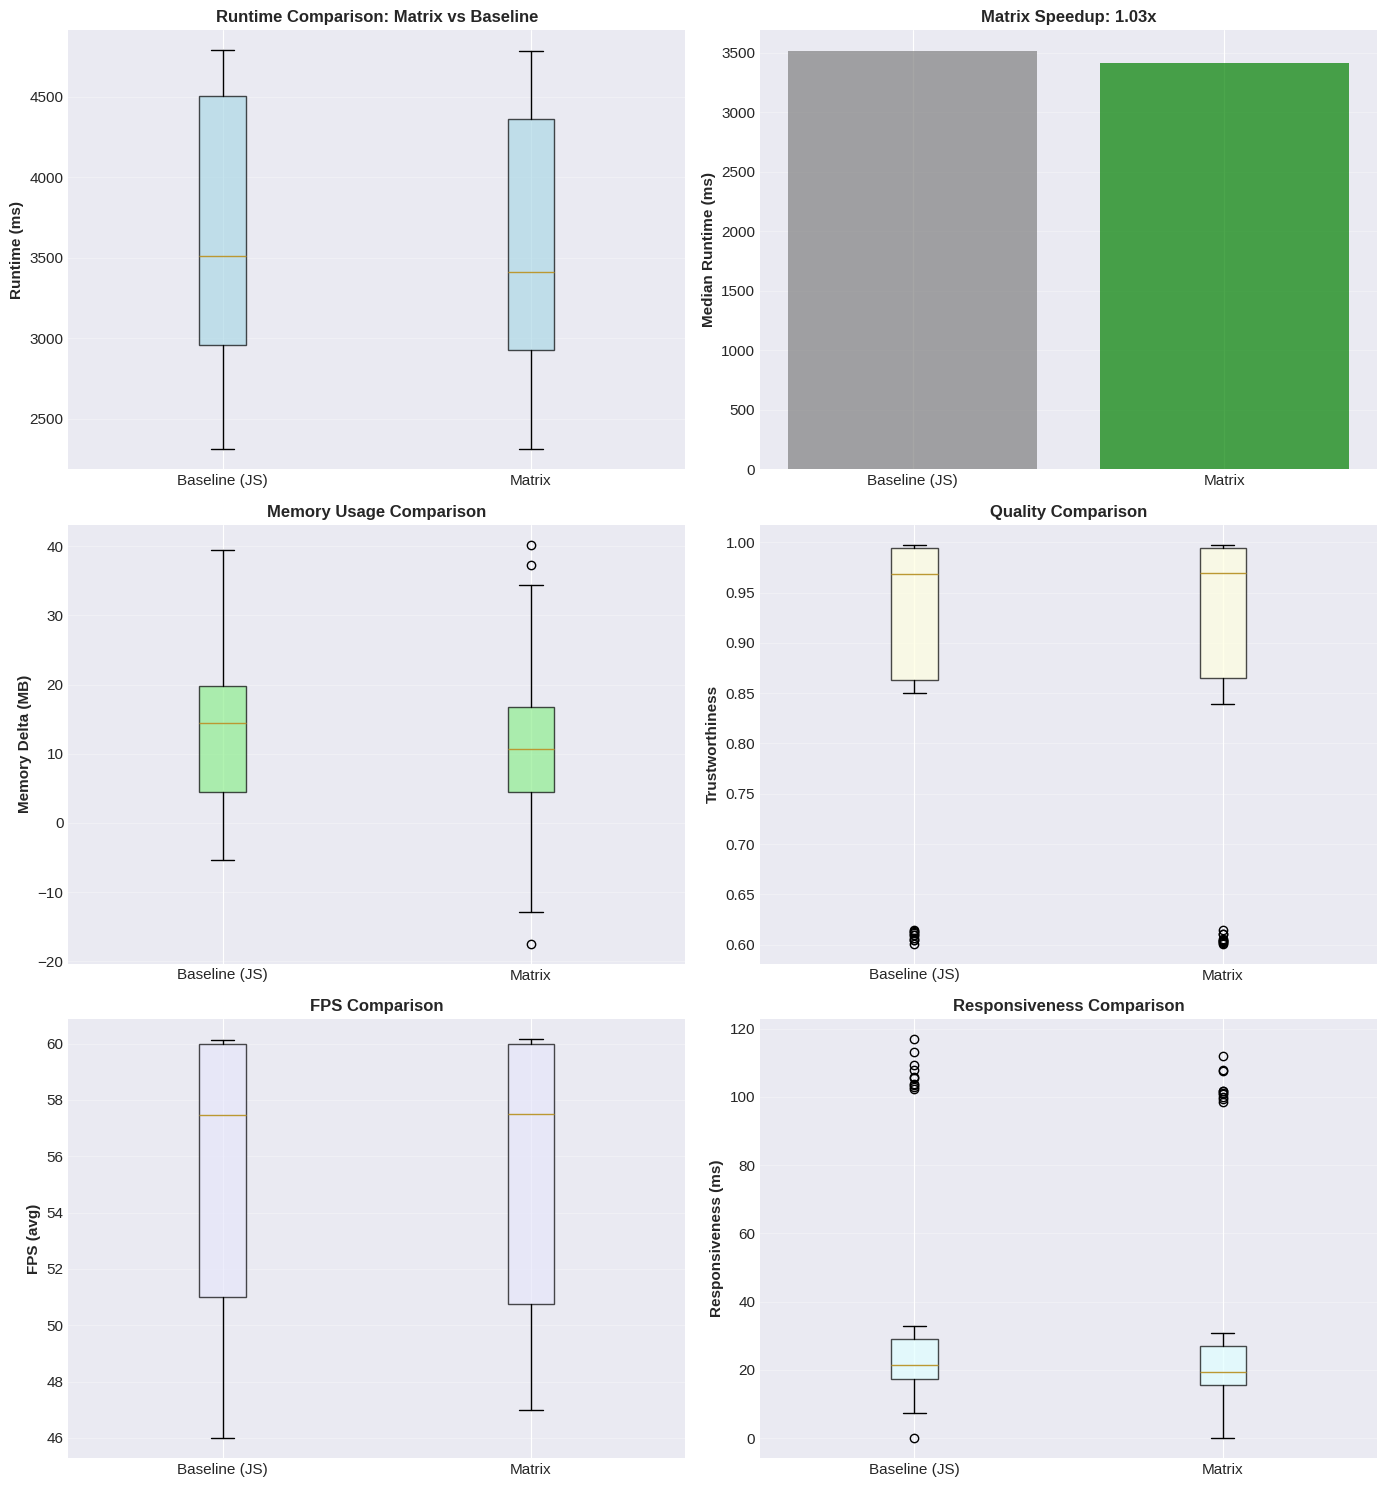

In [152]:
# Visualizations for Matrix Feature
if len(matrix_df) > 0:
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))
    
    # Runtime comparison
    axes[0, 0].boxplot([baseline_df['runtime_ms'], matrix_df['runtime_ms']], 
                       labels=['Baseline (JS)', 'Matrix'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Runtime Comparison: Matrix vs Baseline', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Speedup visualization
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        matrix_median = matrix_df['runtime_ms'].median()
        speedup = baseline_median / matrix_median
        
        axes[0, 1].bar(['Baseline (JS)', 'Matrix'], 
                      [baseline_median, matrix_median],
                      color=['gray', 'green' if speedup > 1 else 'red'],
                      alpha=0.7)
        axes[0, 1].set_ylabel('Median Runtime (ms)', fontsize=11, fontweight='bold')
        axes[0, 1].set_title(f'Matrix Speedup: {speedup:.2f}x', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Memory comparison
    axes[1, 0].boxplot([baseline_df['memory_delta_mb'], matrix_df['memory_delta_mb']], 
                       labels=['Baseline (JS)', 'Matrix'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1, 0].set_ylabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Memory Usage Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Quality comparison
    axes[1, 1].boxplot([baseline_df['trustworthiness'], matrix_df['trustworthiness']], 
                       labels=['Baseline (JS)', 'Matrix'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightyellow', alpha=0.7))
    axes[1, 1].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Quality Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # FPS comparison
    axes[2, 0].boxplot([baseline_df['fps_avg'], matrix_df['fps_avg']], 
                       labels=['Baseline (JS)', 'Matrix'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lavender', alpha=0.7))
    axes[2, 0].set_ylabel('FPS (avg)', fontsize=11, fontweight='bold')
    axes[2, 0].set_title('FPS Comparison', fontsize=12, fontweight='bold')
    axes[2, 0].grid(axis='y', alpha=0.3)
    
    # Responsiveness comparison
    axes[2, 1].boxplot([baseline_df['responsiveness_ms'], matrix_df['responsiveness_ms']], 
                       labels=['Baseline (JS)', 'Matrix'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightcyan', alpha=0.7))
    axes[2, 1].set_ylabel('Responsiveness (ms)', fontsize=11, fontweight='bold')
    axes[2, 1].set_title('Responsiveness Comparison', fontsize=12, fontweight='bold')
    axes[2, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/matrix_comparison.png', bbox_inches='tight')
    plt.show()
else:
    print("No visualizations available (insufficient data)")


### 4.5 NN Descent Feature (WASM)

Performance metrics for WASM-accelerated nearest neighbor descent.

In [153]:
# Data Quality Checks
print("Data Quality Checks:")
print(f"Negative runtime values: {(df_analysis['runtime_ms'] < 0).sum()}")
print(f"Trustworthiness out of range [0,1]: {(~df_analysis['trustworthiness'].between(0, 1)).sum()}")
print(f"Negative FPS: {(df_analysis['fps_avg'] < 0).sum()}")
print(f"\nRuntime statistics by feature:")
df_analysis.groupby('feature_name')['runtime_ms'].describe()

Data Quality Checks:
Negative runtime values: 0
Trustworthiness out of range [0,1]: 0
Negative FPS: 0

Runtime statistics by feature:


,count,mean,std,min,25%,50%,75%,max
feature_name,,,,,,,,
All Features,40.0,2716.918,935.671,1553.4,1903.750,2781.80,3533.325,4111.7
Baseline (JS),60.0,3552.003,827.634,2316.5,2959.925,3512.85,4508.850,4790.0
Distance,60.0,3610.205,871.606,2345.6,2959.250,3504.15,4533.575,5896.3
Matrix,60.0,3501.413,811.153,2312.3,2928.300,3415.65,4364.975,4788.4
NN Descent,60.0,3603.920,844.058,2366.2,2959.625,3489.85,4530.225,5295.8
Optimizer,40.0,2772.847,882.162,1587.7,2088.575,2772.75,3611.500,3966.0
Tree,60.0,3496.438,788.287,2314.5,2956.050,3478.60,4309.850,4722.8


## 5. Performance Distribution Analysis

Analyze the performance distribution across different features for the selected machine.

In [154]:
# Summary statistics by feature
feature_summary = df_analysis.groupby('feature_name').agg({
    'runtime_ms': ['count', 'mean', 'std', 'median', 'min', 'max'],
    'memory_delta_mb': ['mean', 'median'],
    'trustworthiness': ['mean', 'median'],
    'fps_avg': ['mean', 'median'],
    'responsiveness_ms': ['mean', 'median']
}).round(2)

print("Performance Summary:")
feature_summary

Performance Summary:


runtime_ms                                           memory_delta_mb        trustworthiness         \
                   count     mean     std   median     min     max            mean median            mean median   
feature_name                                                                                                       
All Features          40  2716.92  935.67  2781.80  1553.4  4111.7           13.97  16.27            0.88   0.97   
Baseline (JS)         60  3552.00  827.63  3512.85  2316.5  4790.0           13.00  14.48            0.90   0.97   
Distance              60  3610.20  871.61  3504.15  2345.6  5896.3           11.69  12.28            0.90   0.97   
Matrix                60  3501.41  811.15  3415.65  2312.3  4788.4           11.78  10.72            0.90   0.97   
NN Descent            60  3603.92  844.06  3489.85  2366.2  5295.8           17.98  16.87            0.90   0.97   
Optimizer             40  2772.85  882.16  2772.75  1587.7  3966.0           10.59   9.75            0.88   0.97   
Tree                  60  3496.44  788.29  3478.60  2314.5  4722.8           14.37   9.78            0.90   0.97   

              fps_avg        responsiveness_ms         
                 mean median              mean median  
feature_name                                           
All Features    41.88  39.46             40.23  22.03  
Baseline (JS)   55.43  57.46             34.20  21.49  
Distance        55.15  57.46             35.15  21.53  
Matrix          55.55  57.51             31.79  19.52  
NN Descent      55.31  57.01             34.70  20.43  
Optimizer       43.09  42.06             45.04  25.46  
Tree            55.30  56.98             32.76  20.82

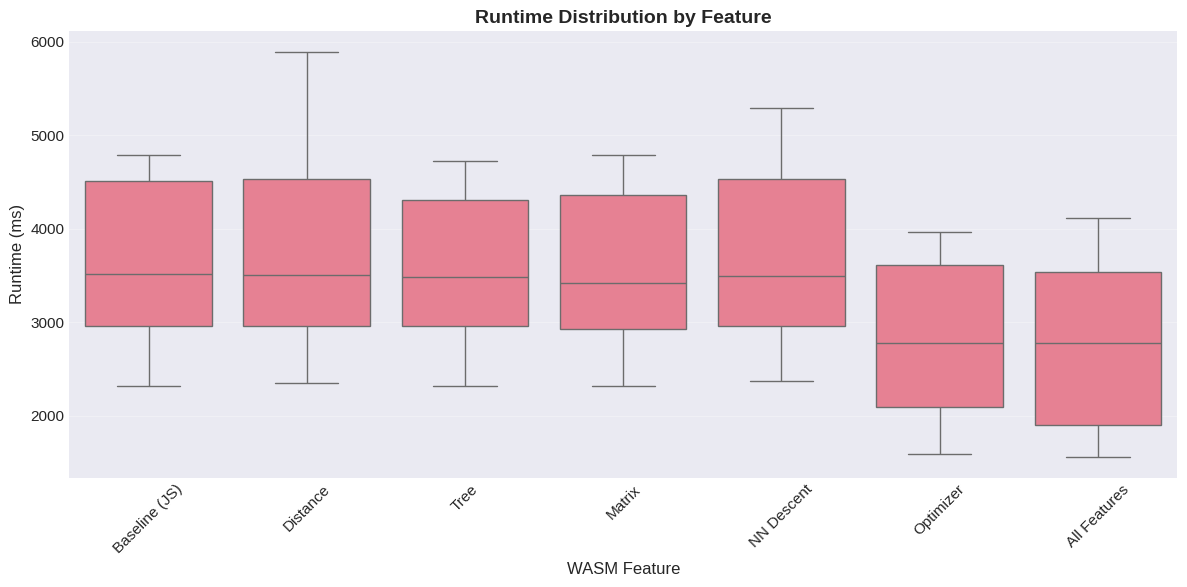

In [155]:
# Visualize runtime distribution by feature
fig, ax = plt.subplots(figsize=(12, 6))

# Order features logically
feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_analysis['feature_name'].unique()]

sns.boxplot(data=df_analysis, x='feature_name', y='runtime_ms', 
            order=feature_order, ax=ax, showfliers=False)
ax.set_title('Runtime Distribution by Feature', fontsize=14, fontweight='bold')
ax.set_xlabel('WASM Feature', fontsize=12)
ax.set_ylabel('Runtime (ms)', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/runtime_distribution.png', bbox_inches='tight')
plt.show()

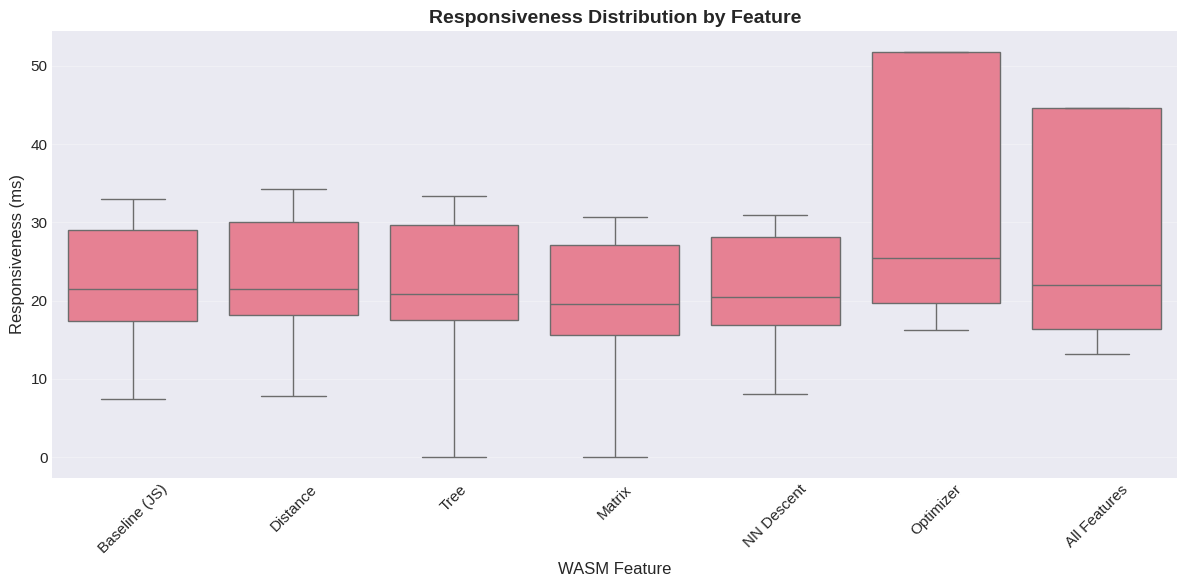

In [156]:
# Visualize responsiveness distribution by feature
fig, ax = plt.subplots(figsize=(12, 6))

# Order features logically
feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_analysis['feature_name'].unique()]

sns.boxplot(data=df_analysis, x='feature_name', y='responsiveness_ms', 
            order=feature_order, ax=ax, showfliers=False)
ax.set_title('Responsiveness Distribution by Feature', fontsize=14, fontweight='bold')
ax.set_xlabel('WASM Feature', fontsize=12)
ax.set_ylabel('Responsiveness (ms)', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/responsiveness_distribution.png', bbox_inches='tight')
plt.show()


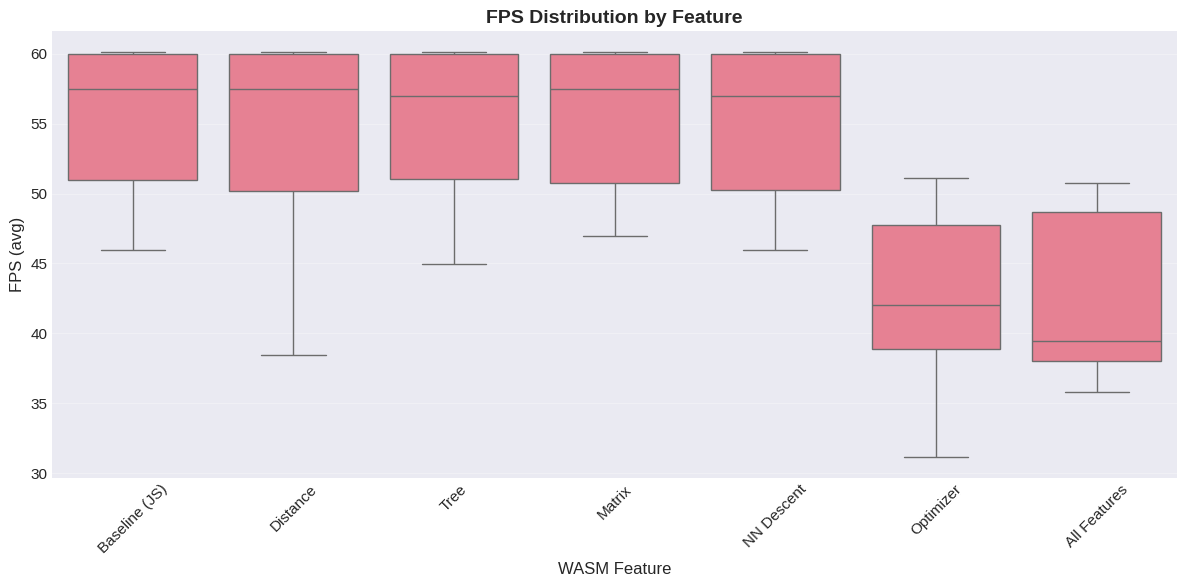

In [157]:
# Visualize FPS distribution by feature
fig, ax = plt.subplots(figsize=(12, 6))

# Order features logically
feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_analysis['feature_name'].unique()]

sns.boxplot(data=df_analysis, x='feature_name', y='fps_avg', 
            order=feature_order, ax=ax, showfliers=False)
ax.set_title('FPS Distribution by Feature', fontsize=14, fontweight='bold')
ax.set_xlabel('WASM Feature', fontsize=12)
ax.set_ylabel('FPS (avg)', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/fps_distribution.png', bbox_inches='tight')
plt.show()


## 6. Comparative Analysis: Speedup Calculations

Compare all features relative to the baseline.

In [158]:
def calculate_speedup(df, baseline_feature='Baseline (JS)', machine=None):
    """
    Calculate speedup relative to baseline for each machine/dataset combination.
    """
    results = []
    
    # Filter by machine if specified
    data = df[df['machine_type'] == machine] if machine else df
    
    # Group by dataset and machine
    for (dataset, mach), group in data.groupby(['dataset_name', 'machine_type']):
        baseline = group[group['feature_name'] == baseline_feature]['runtime_ms']
        
        if len(baseline) == 0:
            continue
            
        baseline_median = baseline.median()
        
        for feature in group['feature_name'].unique():
            if feature == baseline_feature:
                continue
                
            feature_data = group[group['feature_name'] == feature]
            if len(feature_data) == 0:
                continue
            
            feature_median = feature_data['runtime_ms'].median()
            speedup = baseline_median / feature_median
            
            results.append({
                'dataset': dataset,
                'machine': mach,
                'feature': feature,
                'baseline_median_ms': baseline_median,
                'feature_median_ms': feature_median,
                'speedup': speedup,
                'improvement_pct': (speedup - 1) * 100
            })
    
    return pd.DataFrame(results)

# Calculate speedups
speedup_df = calculate_speedup(df_analysis)

print("Speedup Summary:")
speedup_summary = speedup_df.groupby('feature').agg({
    'speedup': ['mean', 'median', 'std', 'min', 'max'],
    'improvement_pct': ['mean', 'median']
}).round(3)
speedup_summary

Speedup Summary:


speedup                             improvement_pct        
                mean median    std    min    max            mean  median
feature                                                                 
All Features   1.557  1.578  0.344  1.183  1.888          55.688  57.830
Distance       0.989  0.994  0.022  0.947  1.008          -1.103  -0.556
Matrix         1.014  1.015  0.007  1.004  1.023           1.370   1.508
NN Descent     0.985  0.991  0.026  0.941  1.014          -1.455  -0.862
Optimizer      1.491  1.470  0.303  1.175  1.848          49.081  47.009
Tree           1.017  1.008  0.023  0.997  1.052           1.666   0.817

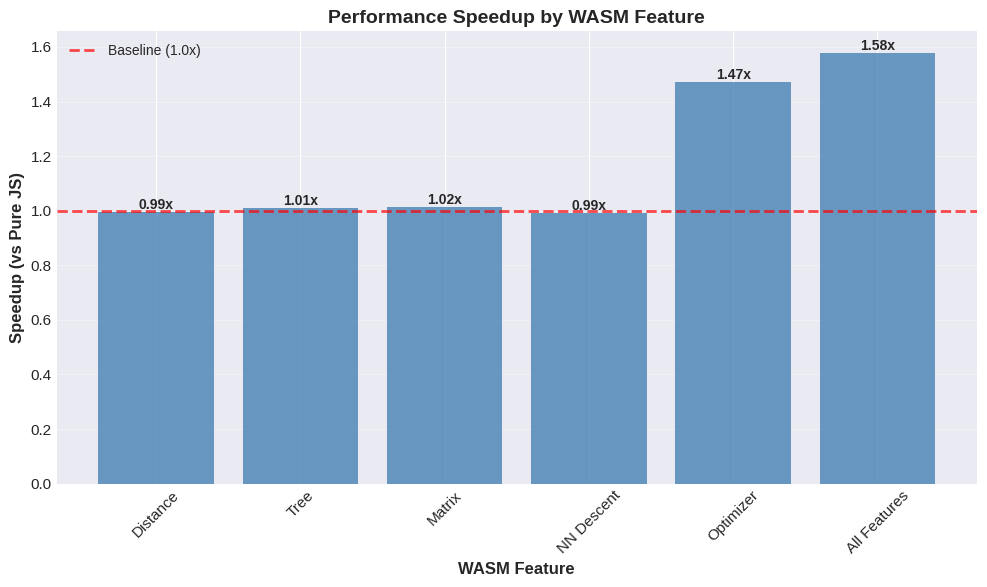

In [159]:
# Detailed speedup by feature
feature_order = ['Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in speedup_df['feature'].unique()]

fig, ax = plt.subplots(figsize=(10, 6))

# Calculate median speedup for each feature
feature_speedups = speedup_df.groupby('feature')['speedup'].median()
values = [feature_speedups.get(f, 0) for f in feature_order]

bars = ax.bar(feature_order, values, alpha=0.8, color='steelblue')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2f}x',
               ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Baseline (1.0x)', alpha=0.7)
ax.set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
ax.set_ylabel('Speedup (vs Pure JS)', fontsize=12, fontweight='bold')
ax.set_title('Performance Speedup by WASM Feature', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_comparison.png', bbox_inches='tight')
plt.show()

## 7. Dataset Size Analysis

Analyze how performance scales with dataset size and whether WASM features show different benefits for small vs large datasets.

In [160]:
# Extract dataset size information from the existing 'dataset_size' column
# This column is already in the CSV from the benchmark runs
df_analysis['dataset_size'] = pd.to_numeric(df_analysis['dataset_size'], errors='coerce')

# Benchmark dataset sizes:
# Small scope: Iris (150), Small Random (80)
# Mid scope: Swiss Roll (600), Medium Clustered (600)
# Large scope: MNIST-like (1000), 3D Dense Clusters (1000)

# Create size categories based on actual benchmark dataset sizes
df_analysis['size_category'] = pd.cut(
    df_analysis['dataset_size'], 
    bins=[0, 200, 800, float('inf')],
    labels=['Small (≤200)', 'Medium (200-800)', 'Large (>800)']
)

print("Dataset Size Distribution:")
print(df_analysis.groupby('dataset_name')['dataset_size'].first().sort_values())
print(f"\nSize category distribution:")
print(df_analysis['size_category'].value_counts().sort_index())

Dataset Size Distribution:
dataset_name
Small Random (80 points)                  80
Iris Dataset (150 points, 4D)            150
Swiss Roll (600 points, 3D manifold)     600
Medium Clustered (600 points)            600
MNIST-like (1K points, 784D)            1000
3D Dense Clusters (1K points)           1000
Name: dataset_size, dtype: int64

Size category distribution:
size_category
Small (≤200)        100
Medium (200-800)    140
Large (>800)        140
Name: count, dtype: int64


In [161]:
# Analyze runtime by dataset size and feature
size_performance = df_analysis.groupby(['dataset_name', 'dataset_size', 'feature_name']).agg({
    'runtime_ms': ['mean', 'median', 'std', 'count']
}).round(2)

print("Runtime by Dataset Size and Feature:")
print("\nSummary statistics:")
size_summary = df_analysis.groupby(['dataset_size', 'feature_name']).agg({
    'runtime_ms': ['mean', 'median', 'std']
}).round(2)
size_summary

Runtime by Dataset Size and Feature:

Summary statistics:


runtime_ms                 
                                 mean   median     std
dataset_size feature_name                             
80           Baseline (JS)    3172.67  3150.00  173.47
             Distance         3320.67  3327.15   94.02
             Matrix           3104.77  3105.45  170.55
             NN Descent       3343.05  3346.00   52.04
             Tree             3046.78  2994.05  145.75
150          Baseline (JS)    2355.61  2350.15   21.12
             Distance         2377.94  2373.80   29.09
             Matrix           2347.30  2336.95   30.03
             NN Descent       2394.89  2388.25   22.20
             Tree             2354.02  2352.90   24.42
600          All Features     1826.97  1804.60  265.57
             Baseline (JS)    3325.39  3319.80  369.62
             Distance         3317.73  3340.85  347.69
             Matrix           3277.33  3269.05  342.67
             NN Descent       3297.37  3286.65  346.68
             Optimizer        1954.51  1993.35  343.73
             Tree             3356.70  3341.35  405.44
1000         All Features     3606.87  3597.45  243.12
             Baseline (JS)    4566.48  4535.25   97.41
             Distance         4663.57  4562.20  363.64
             Matrix           4500.87  4447.45  152.78
             NN Descent       4645.42  4590.80  211.40
             Optimizer        3591.19  3612.40  263.37
             Tree             4432.21  4380.40  138.69

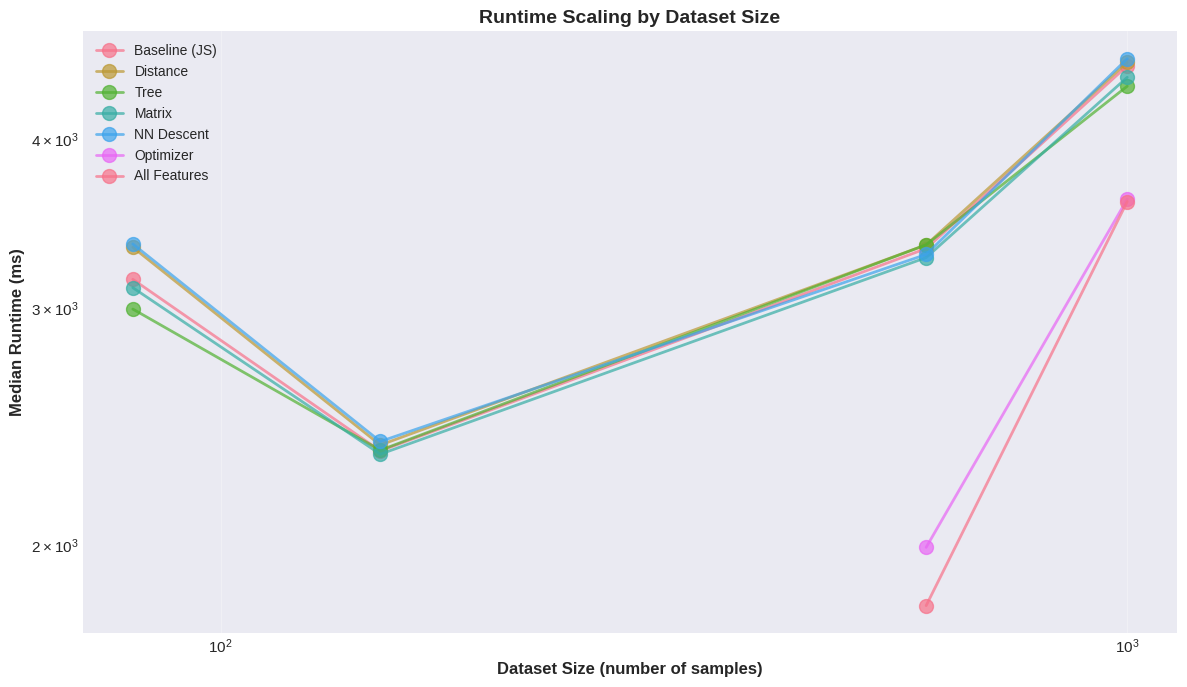

Note: Log-log scale used to show scaling behavior across different dataset sizes.

Data point counts per feature:
  Baseline (JS): 4 dataset size(s)
  Distance: 4 dataset size(s)
  Tree: 4 dataset size(s)
  Matrix: 4 dataset size(s)
  NN Descent: 4 dataset size(s)
  Optimizer: 2 dataset size(s)
  All Features: 2 dataset size(s)


In [162]:
# Visualize runtime scaling with dataset size
fig, ax = plt.subplots(figsize=(12, 7))

feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_analysis['feature_name'].unique()]

for feature in feature_order:
    feature_data = df_analysis[df_analysis['feature_name'] == feature]
    if len(feature_data) == 0:
        continue
    
    # Group by dataset size and calculate median runtime
    size_runtime = feature_data.groupby('dataset_size')['runtime_ms'].median().sort_index()
    
    # Plot with both lines and markers (larger markers for visibility)
    ax.plot(size_runtime.index, size_runtime.values, 
           marker='o', label=feature, linewidth=2, markersize=10, alpha=0.7)

ax.set_xlabel('Dataset Size (number of samples)', fontsize=12, fontweight='bold')
ax.set_ylabel('Median Runtime (ms)', fontsize=12, fontweight='bold')
ax.set_title('Runtime Scaling by Dataset Size', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.savefig('../outputs/figures/runtime_scaling_by_size.png', bbox_inches='tight')
plt.show()

print("Note: Log-log scale used to show scaling behavior across different dataset sizes.")
print(f"\nData point counts per feature:")
for feature in feature_order:
    feature_data = df_analysis[df_analysis['feature_name'] == feature]
    size_count = feature_data.groupby('dataset_size').ngroups
    print(f"  {feature}: {size_count} dataset size(s)")

In [163]:
# Analyze speedup by dataset size
def calculate_speedup_by_size(df, baseline_feature='Baseline (JS)'):
    """
    Calculate speedup relative to baseline for each dataset size.
    """
    results = []
    
    for (size, machine), group in df.groupby(['dataset_size', 'machine_type']):
        baseline = group[group['feature_name'] == baseline_feature]['runtime_ms']
        
        if len(baseline) == 0:
            continue
            
        baseline_median = baseline.median()
        
        for feature in group['feature_name'].unique():
            if feature == baseline_feature:
                continue
                
            feature_data = group[group['feature_name'] == feature]
            if len(feature_data) == 0:
                continue
            
            feature_median = feature_data['runtime_ms'].median()
            speedup = baseline_median / feature_median
            
            results.append({
                'dataset_size': size,
                'machine': machine,
                'feature': feature,
                'baseline_median_ms': baseline_median,
                'feature_median_ms': feature_median,
                'speedup': speedup,
                'improvement_pct': (speedup - 1) * 100
            })
    
    return pd.DataFrame(results)

speedup_by_size_df = calculate_speedup_by_size(df_analysis)

print("Speedup by Dataset Size:")
print("\nAverage speedup across size categories:")
speedup_summary_by_size = speedup_by_size_df.groupby('feature').agg({
    'speedup': ['mean', 'median', 'std'],
    'improvement_pct': ['mean', 'median']
}).round(3)
speedup_summary_by_size

Speedup by Dataset Size:

Average speedup across size categories:


speedup               improvement_pct        
                mean median    std            mean  median
feature                                                   
All Features   1.550  1.550  0.409          55.016  55.016
Distance       0.981  0.992  0.023          -1.885  -0.813
Matrix         1.014  1.015  0.006           1.382   1.494
NN Descent     0.981  0.986  0.029          -1.914  -1.403
Optimizer      1.460  1.460  0.290          46.045  46.045
Tree           1.020  1.017  0.028           1.995   1.709

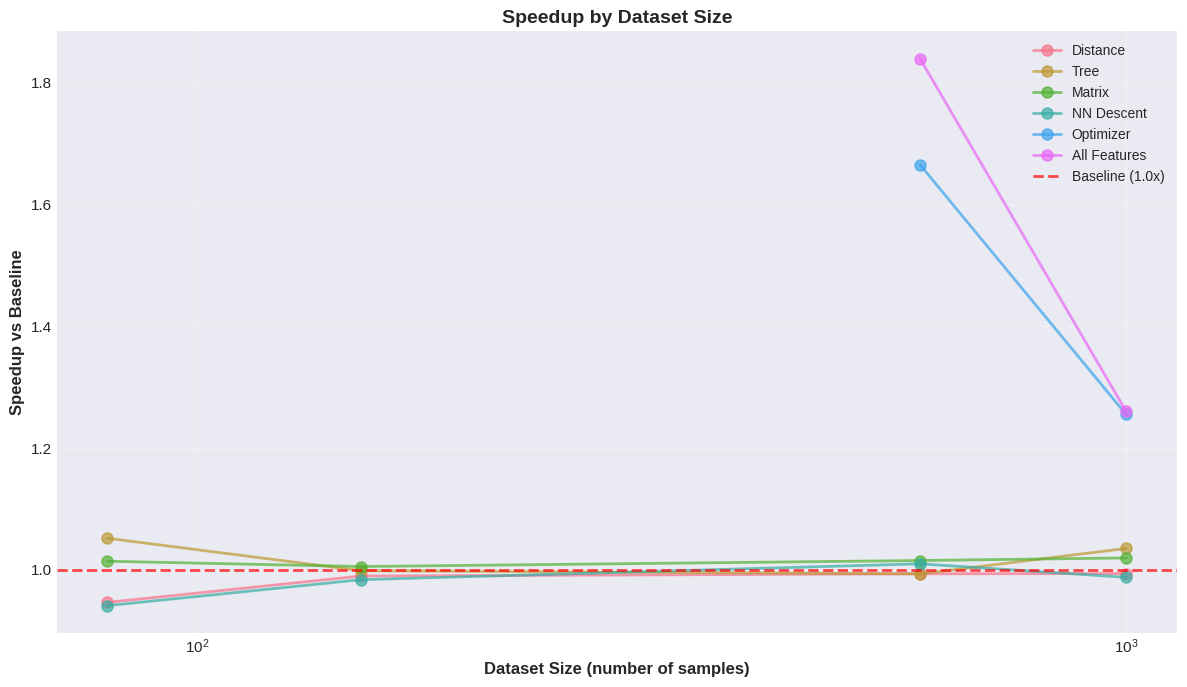

Note: Shows whether WASM benefits increase or decrease with dataset size.


In [164]:
# Visualize speedup trends by dataset size
fig, ax = plt.subplots(figsize=(12, 7))

feature_order = ['Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in speedup_by_size_df['feature'].unique()]

for feature in feature_order:
    feature_data = speedup_by_size_df[speedup_by_size_df['feature'] == feature]
    if len(feature_data) == 0:
        continue
    
    # Sort by dataset size
    feature_data = feature_data.sort_values('dataset_size')
    
    ax.plot(feature_data['dataset_size'], feature_data['speedup'], 
           marker='o', label=feature, linewidth=2, markersize=8, alpha=0.7)

ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Baseline (1.0x)')
ax.set_xlabel('Dataset Size (number of samples)', fontsize=12, fontweight='bold')
ax.set_ylabel('Speedup vs Baseline', fontsize=12, fontweight='bold')
ax.set_title('Speedup by Dataset Size', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(alpha=0.3)
ax.set_xscale('log')

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_by_dataset_size.png', bbox_inches='tight')
plt.show()

print("Note: Shows whether WASM benefits increase or decrease with dataset size.")

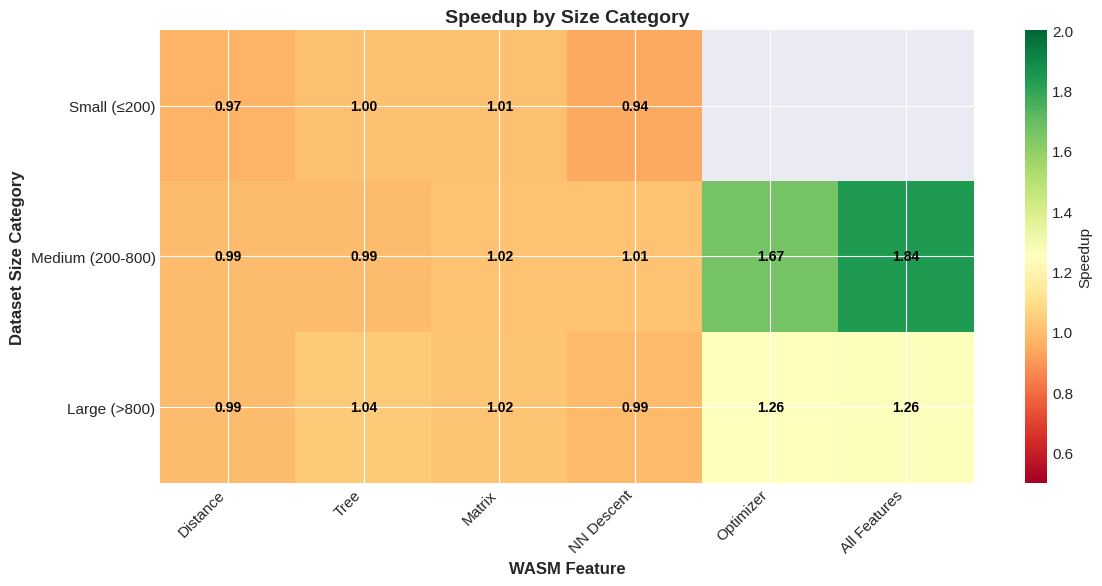

Note: Green = faster than baseline, Red = slower than baseline


In [165]:
# Heatmap of speedup by size category and feature
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate speedup for each size category and feature
speedup_matrix = []
size_cats = df_analysis['size_category'].dropna().unique()
size_cats = sorted(size_cats, key=lambda x: ['Small (≤200)', 'Medium (200-800)', 'Large (>800)'].index(x) if x in ['Small (≤200)', 'Medium (200-800)', 'Large (>800)'] else 999)

for size_cat in size_cats:
    size_data = df_analysis[df_analysis['size_category'] == size_cat]
    baseline = size_data[size_data['feature_name'] == 'Baseline (JS)']['runtime_ms'].median()
    
    if pd.isna(baseline) or baseline == 0:
        continue
    
    row = []
    for feature in feature_order:
        feature_data = size_data[size_data['feature_name'] == feature]
        if len(feature_data) > 0:
            speedup = baseline / feature_data['runtime_ms'].median()
            row.append(speedup)
        else:
            row.append(np.nan)
    
    if row:
        speedup_matrix.append(row)

if speedup_matrix:
    speedup_matrix = np.array(speedup_matrix)
    
    im = ax.imshow(speedup_matrix, cmap='RdYlGn', aspect='auto', vmin=0.5, vmax=2.0)
    ax.set_xticks(np.arange(len(feature_order)))
    ax.set_yticks(np.arange(len(size_cats[:len(speedup_matrix)])))
    ax.set_xticklabels(feature_order, rotation=45, ha='right')
    ax.set_yticklabels(size_cats[:len(speedup_matrix)])
    ax.set_title('Speedup by Size Category', fontsize=14, fontweight='bold')
    ax.set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
    ax.set_ylabel('Dataset Size Category', fontsize=12, fontweight='bold')
    
    # Add text annotations
    for i in range(len(speedup_matrix)):
        for j in range(len(feature_order)):
            if not np.isnan(speedup_matrix[i, j]):
                text = ax.text(j, i, f'{speedup_matrix[i, j]:.2f}',
                            ha="center", va="center", color="black", fontsize=10, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Speedup', fontsize=11)

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_heatmap_by_size.png', bbox_inches='tight')
plt.show()

print("Note: Green = faster than baseline, Red = slower than baseline")

In [166]:
# Summary statistics: Speedup by size category
print("=" * 80)
print("DATASET SIZE ANALYSIS SUMMARY")
print("=" * 80)

# Group by feature and calculate statistics
size_analysis = speedup_by_size_df.groupby('feature').agg({
    'speedup': ['mean', 'median', 'min', 'max', 'std']
}).round(3)

print(size_analysis)

# Find which features scale better with size
print(f"\nScaling behavior:")
for feature in speedup_by_size_df['feature'].unique():
    feat_data = speedup_by_size_df[speedup_by_size_df['feature'] == feature].sort_values('dataset_size')
    if len(feat_data) > 1:
        # Simple trend: compare smallest vs largest
        small_speedup = feat_data.iloc[0]['speedup']
        large_speedup = feat_data.iloc[-1]['speedup']
        trend = "improves" if large_speedup > small_speedup else "degrades"
        print(f"  {feature}: {trend} with size ({small_speedup:.2f}x → {large_speedup:.2f}x)")

print("\n" + "=" * 80)

DATASET SIZE ANALYSIS SUMMARY
             speedup                            
                mean median    min    max    std
feature                                         
All Features   1.550  1.550  1.261  1.840  0.409
Distance       0.981  0.992  0.947  0.994  0.023
Matrix         1.014  1.015  1.006  1.020  0.006
NN Descent     0.981  0.986  0.941  1.010  0.029
Optimizer      1.460  1.460  1.255  1.665  0.290
Tree           1.020  1.017  0.994  1.052  0.028

Scaling behavior:
  Distance: improves with size (0.95x → 0.99x)
  Tree: degrades with size (1.05x → 1.04x)
  Matrix: improves with size (1.01x → 1.02x)
  NN Descent: improves with size (0.94x → 0.99x)
  All Features: degrades with size (1.84x → 1.26x)
  Optimizer: degrades with size (1.67x → 1.26x)



## 8. Statistical Testing

Perform rigorous statistical tests to determine if differences are significant.

In [167]:
def mann_whitney_test(df, baseline_feature='Baseline (JS)'):
    """
    Perform Mann-Whitney U test comparing each feature to baseline.
    """
    results = []
    
    baseline = df[df['feature_name'] == baseline_feature]['runtime_ms'].dropna()
    
    if len(baseline) < 3:
        print("Insufficient baseline data for testing")
        return pd.DataFrame()
    
    for feature in df['feature_name'].unique():
        if feature == baseline_feature:
            continue
        
        feature_data = df[df['feature_name'] == feature]['runtime_ms'].dropna()
        
        if len(feature_data) < 3:
            continue
        
        # Mann-Whitney U test
        statistic, p_value = mannwhitneyu(baseline, feature_data, alternative='two-sided')
        
        # Effect size (Cohen's d approximation)
        mean_diff = feature_data.mean() - baseline.mean()
        pooled_std = np.sqrt((baseline.std()**2 + feature_data.std()**2) / 2)
        cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
        
        # Cliff's Delta (effect size for non-parametric test)
        n1, n2 = len(baseline), len(feature_data)
        pairs_greater = sum(1 for b in baseline for f in feature_data if b > f)
        pairs_less = sum(1 for b in baseline for f in feature_data if b < f)
        cliffs_delta = (pairs_greater - pairs_less) / (n1 * n2)
        
        results.append({
            'feature': feature,
            'n_baseline': len(baseline),
            'n_feature': len(feature_data),
            'baseline_median': baseline.median(),
            'feature_median': feature_data.median(),
            'p_value': p_value,
            'significant': p_value < 0.05,
            'cohens_d': cohens_d,
            'cliffs_delta': cliffs_delta
        })
    
    return pd.DataFrame(results)

# Perform tests
test_results = mann_whitney_test(df_analysis)

print("Statistical Test Results (Mann-Whitney U Test):")
print("\nSignificance: p < 0.05")
print("Cliff's Delta interpretation: |δ| < 0.147 (negligible), < 0.33 (small), < 0.474 (medium), >= 0.474 (large)\n")
test_results.round(4)

Statistical Test Results (Mann-Whitney U Test):

Significance: p < 0.05
Cliff's Delta interpretation: |δ| < 0.147 (negligible), < 0.33 (small), < 0.474 (medium), >= 0.474 (large)



,feature,n_baseline,n_feature,baseline_median,feature_median,p_value,significant,cohens_d,cliffs_delta
0,Distance,60,60,3512.85,3504.15,6.997e-01,False,0.069,-0.041
1,Tree,60,60,3512.85,3478.60,4.388e-01,False,-0.069,0.082
2,Matrix,60,60,3512.85,3415.65,3.048e-01,False,-0.062,0.109
3,NN Descent,60,60,3512.85,3489.85,5.979e-01,False,0.062,-0.056
4,All Features,60,40,3512.85,2781.80,3.000e-04,True,-0.945,0.430
5,Optimizer,60,40,3512.85,2772.75,2.000e-04,True,-0.911,0.438


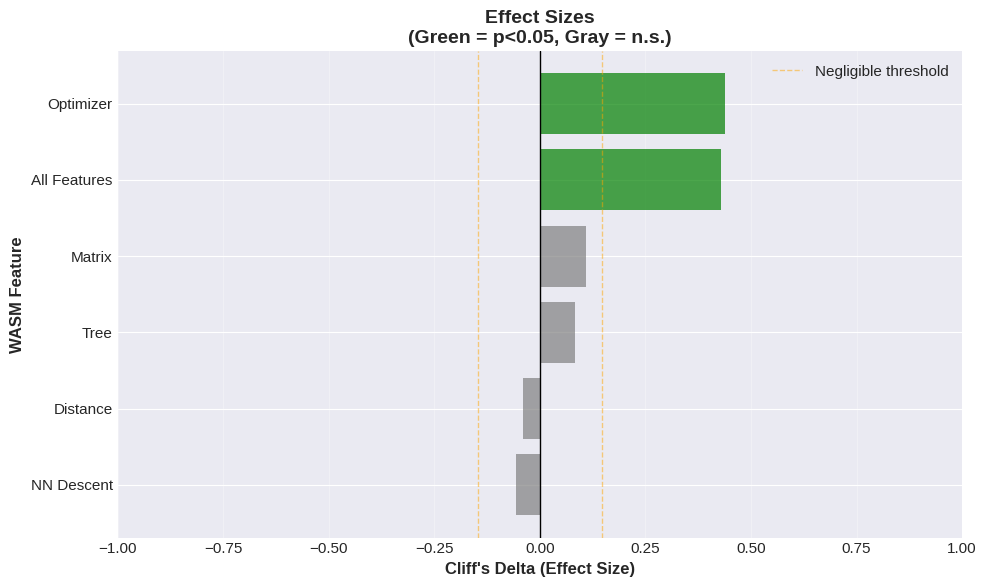

Note: Negative Cliff's Delta = feature is faster than baseline
      Positive Cliff's Delta = feature is slower than baseline


In [168]:
# Visualize statistical significance
fig, ax = plt.subplots(figsize=(10, 6))

if len(test_results) > 0:
    # Sort by Cliff's delta
    test_results_sorted = test_results.sort_values('cliffs_delta')
    
    colors = ['green' if sig else 'gray' for sig in test_results_sorted['significant']]
    
    ax.barh(test_results_sorted['feature'], test_results_sorted['cliffs_delta'], color=colors, alpha=0.7)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax.axvline(x=-0.147, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Negligible threshold')
    ax.axvline(x=0.147, color='orange', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel("Cliff's Delta (Effect Size)", fontsize=12, fontweight='bold')
    ax.set_ylabel('WASM Feature', fontsize=12, fontweight='bold')
    ax.set_title('Effect Sizes\n(Green = p<0.05, Gray = n.s.)', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlim(-1, 1)
    ax.legend()

plt.tight_layout()
plt.savefig('../outputs/figures/effect_sizes.png', bbox_inches='tight')
plt.show()

print("Note: Negative Cliff's Delta = feature is faster than baseline")
print("      Positive Cliff's Delta = feature is slower than baseline")

## 9. Bootstrap Confidence Intervals

Calculate robust confidence intervals for median speedups using bootstrap resampling.

In [169]:
def bootstrap_speedup_ci(df, baseline_feature='Baseline (JS)', n_bootstrap=10000, confidence=0.95):
    """
    Calculate bootstrap confidence intervals for speedup.
    """
    results = []
    rng = np.random.default_rng(42)
    
    baseline = df[df['feature_name'] == baseline_feature]['runtime_ms'].dropna().values
    
    if len(baseline) < 3:
        print("Insufficient baseline data for bootstrap")
        return pd.DataFrame()
    
    for feature in df['feature_name'].unique():
        if feature == baseline_feature:
            continue
        
        feature_data = df[df['feature_name'] == feature]['runtime_ms'].dropna().values
        
        if len(feature_data) < 3:
            continue
        
        # Bootstrap speedup
        speedups = []
        for _ in range(n_bootstrap):
            base_sample = rng.choice(baseline, size=len(baseline), replace=True)
            feat_sample = rng.choice(feature_data, size=len(feature_data), replace=True)
            speedup = np.median(base_sample) / np.median(feat_sample)
            speedups.append(speedup)
        
        speedups = np.array(speedups)
        alpha = 1 - confidence
        ci_lower = np.percentile(speedups, alpha/2 * 100)
        ci_upper = np.percentile(speedups, (1 - alpha/2) * 100)
        
        results.append({
            'feature': feature,
            'speedup_median': np.median(speedups),
            'speedup_mean': np.mean(speedups),
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'ci_width': ci_upper - ci_lower
        })
    
    return pd.DataFrame(results)

# Calculate bootstrap CIs
print("Calculating bootstrap confidence intervals (10,000 iterations)...")
bootstrap_results = bootstrap_speedup_ci(df_analysis)

print("\nBootstrap 95% Confidence Intervals for Speedup:\n")
bootstrap_results.round(3)

Calculating bootstrap confidence intervals (10,000 iterations)...

Bootstrap 95% Confidence Intervals for Speedup:



,feature,speedup_median,speedup_mean,ci_lower,ci_upper,ci_width
0,Distance,0.997,0.991,0.834,1.108,0.273
1,Tree,1.009,1.026,0.834,1.216,0.382
2,Matrix,1.016,1.023,0.842,1.221,0.379
3,NN Descent,1.001,0.994,0.839,1.101,0.263
4,All Features,1.270,1.323,0.905,1.801,0.896
5,Optimizer,1.252,1.275,0.944,1.617,0.673


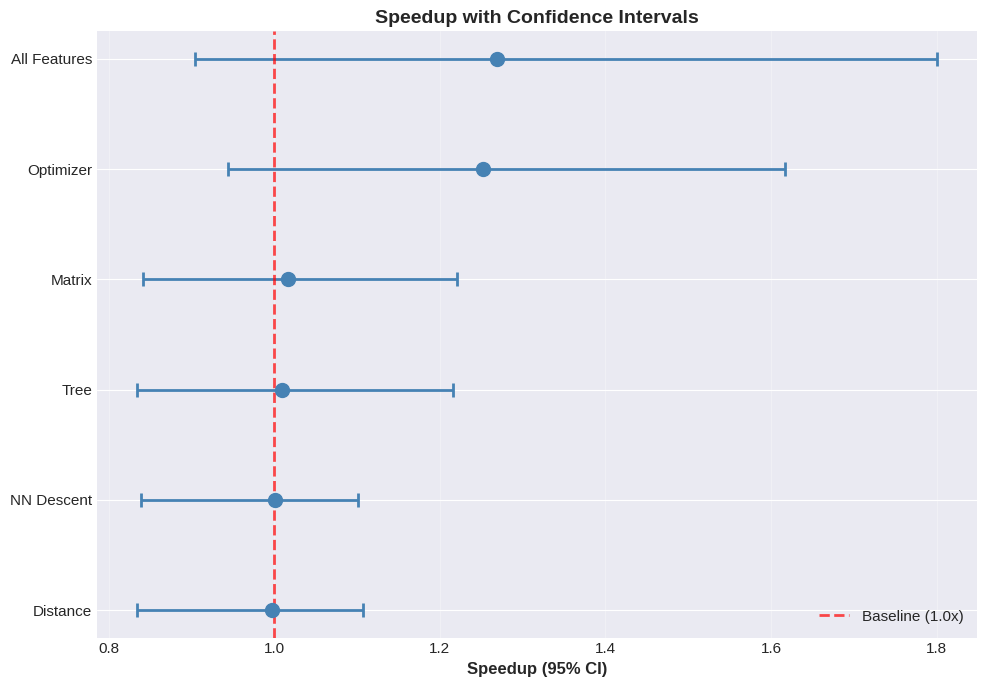

In [170]:
# Visualize confidence intervals
fig, ax = plt.subplots(figsize=(10, 7))

if len(bootstrap_results) > 0:
    bootstrap_results_sorted = bootstrap_results.sort_values('speedup_median')
    
    y_pos = np.arange(len(bootstrap_results_sorted))
    
    # Plot error bars
    ax.errorbar(
        bootstrap_results_sorted['speedup_median'],
        y_pos,
        xerr=[
            bootstrap_results_sorted['speedup_median'] - bootstrap_results_sorted['ci_lower'],
            bootstrap_results_sorted['ci_upper'] - bootstrap_results_sorted['speedup_median']
        ],
        fmt='o',
        markersize=10,
        capsize=5,
        capthick=2,
        elinewidth=2,
        color='steelblue'
    )
    
    ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Baseline (1.0x)', alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(bootstrap_results_sorted['feature'])
    ax.set_xlabel('Speedup (95% CI)', fontsize=12, fontweight='bold')
    ax.set_title('Speedup with Confidence Intervals', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_confidence_intervals.png', bbox_inches='tight')
plt.show()

## 10. Quality and Responsiveness Analysis

Analyze the trade-offs between performance and output quality/responsiveness.

In [171]:
# Quality comparison
feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_analysis['feature_name'].unique()]

quality_summary = df_analysis.groupby('feature_name').agg({
    'trustworthiness': ['mean', 'median', 'std', 'count'],
    'fps_avg': ['mean', 'median'],
    'responsiveness_ms': ['mean', 'median']
}).round(4)

print("Quality and Responsiveness by Feature:\n")
quality_summary

Quality and Responsiveness by Feature:



trustworthiness                     fps_avg         responsiveness_ms        
                         mean median    std count    mean  median              mean  median
feature_name                                                                               
All Features            0.878  0.972  0.180    40  41.885  39.458            40.233  22.033
Baseline (JS)           0.900  0.969  0.139    60  55.425  57.463            34.197  21.487
Distance                0.901  0.969  0.139    60  55.151  57.461            35.152  21.530
Matrix                  0.900  0.970  0.141    60  55.553  57.510            31.793  19.517
NN Descent              0.899  0.970  0.142    60  55.307  57.006            34.699  20.427
Optimizer               0.876  0.971  0.183    40  43.091  42.061            45.042  25.457
Tree                    0.901  0.970  0.139    60  55.296  56.978            32.765  20.817

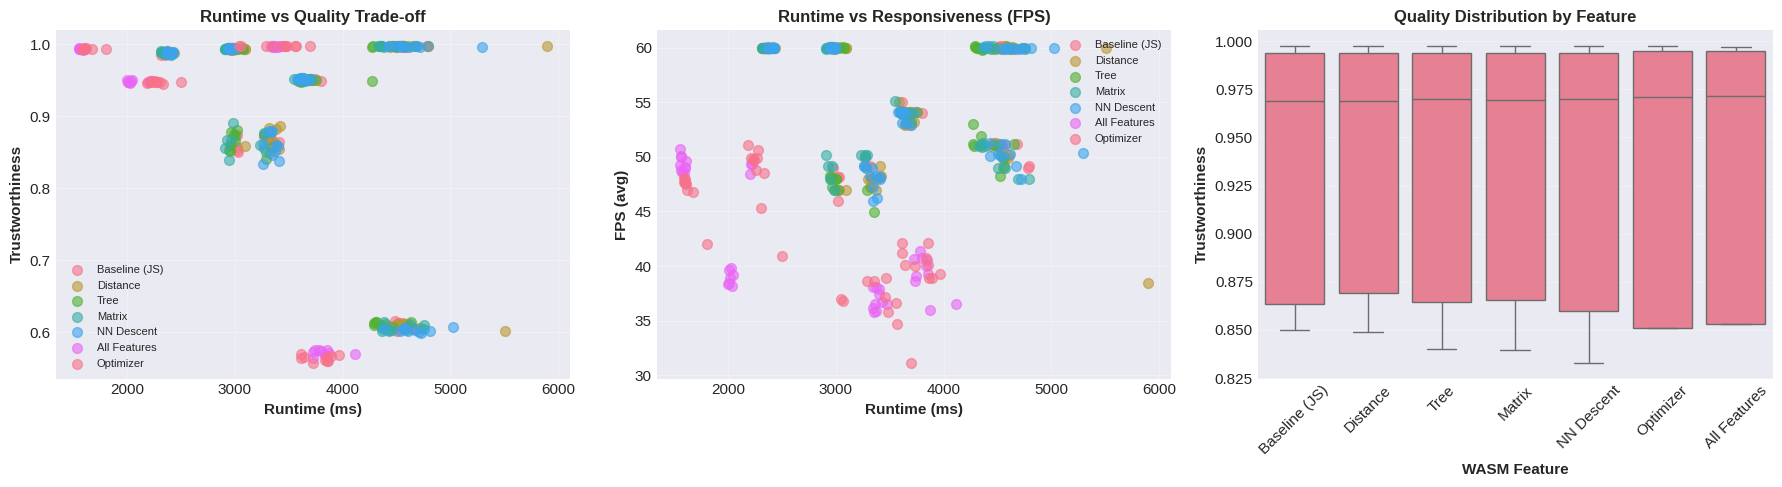

In [172]:
# Visualize quality vs performance trade-off
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Runtime vs Quality
for feature in df_analysis['feature_name'].unique():
    feature_data = df_analysis[df_analysis['feature_name'] == feature]
    axes[0].scatter(feature_data['runtime_ms'], feature_data['trustworthiness'], 
                   label=feature, alpha=0.6, s=50)

axes[0].set_xlabel('Runtime (ms)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
axes[0].set_title('Runtime vs Quality Trade-off', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=8, loc='best')
axes[0].grid(alpha=0.3)

# Runtime vs FPS
for feature in df_analysis['feature_name'].unique():
    feature_data = df_analysis[df_analysis['feature_name'] == feature]
    axes[1].scatter(feature_data['runtime_ms'], feature_data['fps_avg'], 
                   label=feature, alpha=0.6, s=50)

axes[1].set_xlabel('Runtime (ms)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('FPS (avg)', fontsize=11, fontweight='bold')
axes[1].set_title('Runtime vs Responsiveness (FPS)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=8, loc='best')
axes[1].grid(alpha=0.3)

# Quality by feature (boxplot)
sns.boxplot(data=df_analysis, x='feature_name', y='trustworthiness', 
            order=feature_order, ax=axes[2], showfliers=False)
axes[2].set_xlabel('WASM Feature', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
axes[2].set_title('Quality Distribution by Feature', fontsize=12, fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/quality_tradeoffs.png', bbox_inches='tight')
plt.show()

## 11. Feature Ranking and Recommendations

Rank features based on multiple criteria for practical recommendations.

In [173]:
# Calculate composite scores
def calculate_composite_scores(df, baseline='Baseline (JS)'):
    """
    Calculate composite performance scores for each feature.
    """
    results = []
    
    for feature in df['feature_name'].unique():
        if feature == baseline:
            continue
        
        feature_data = df[df['feature_name'] == feature]
        baseline_data = df[df['feature_name'] == baseline]
        
        # Calculate metrics relative to baseline
        speedup = baseline_data['runtime_ms'].median() / feature_data['runtime_ms'].median()
        quality_ratio = feature_data['trustworthiness'].median() / baseline_data['trustworthiness'].median()
        fps_ratio = feature_data['fps_avg'].median() / baseline_data['fps_avg'].median()
        
        # Memory impact (negative is better)
        memory_delta = feature_data['memory_delta_mb'].median()
        
        # Composite score (higher is better)
        # Weights: 50% speedup, 25% quality, 15% FPS, 10% memory
        composite = (0.50 * speedup + 
                    0.25 * quality_ratio + 
                    0.15 * fps_ratio - 
                    0.10 * abs(memory_delta / 10))  # Normalize memory
        
        results.append({
            'feature': feature,
            'speedup': speedup,
            'quality_ratio': quality_ratio,
            'fps_ratio': fps_ratio,
            'memory_delta_mb': memory_delta,
            'composite_score': composite
        })
    
    return pd.DataFrame(results).sort_values('composite_score', ascending=False)

# Calculate rankings
print("Feature Rankings by Composite Score:\n")
print('='*70)
rankings = calculate_composite_scores(df_analysis)
print(rankings.round(3).to_string(index=False))

Feature Rankings by Composite Score:

     feature  speedup  quality_ratio  fps_ratio  memory_delta_mb  composite_score
   Optimizer    1.267          1.003      0.732            9.745            0.896
All Features    1.263          1.003      0.687           16.272            0.822
      Matrix    1.028          1.001      1.001           10.721            0.807
        Tree    1.010          1.001      0.992            9.784            0.806
    Distance    1.002          1.000      1.000           12.275            0.779
  NN Descent    1.007          1.001      0.992           16.870            0.734


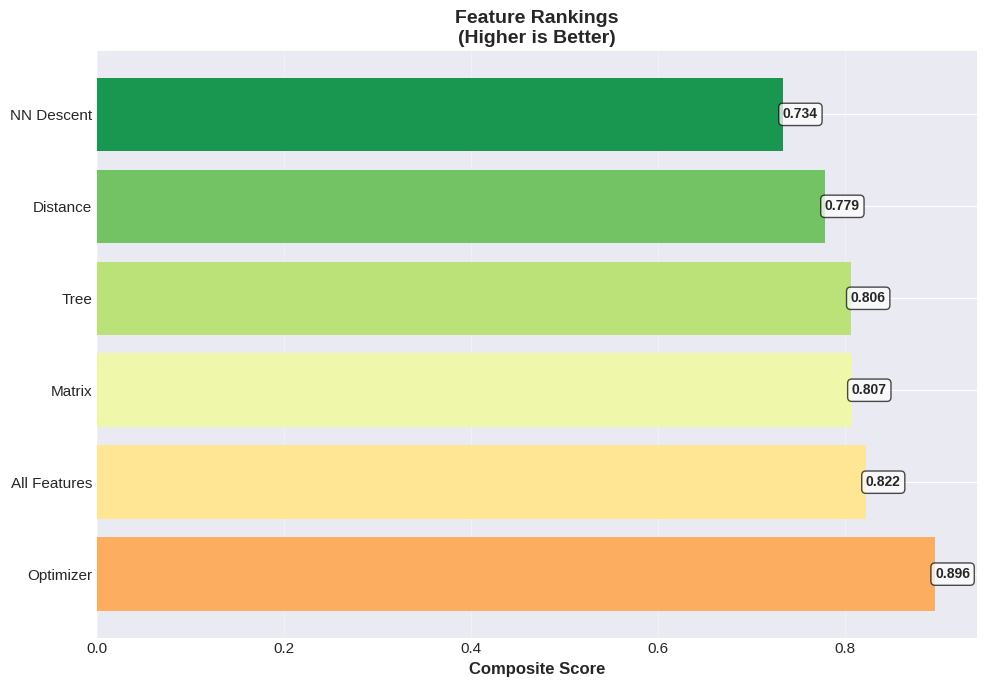

In [174]:
# Visualize feature rankings
fig, ax = plt.subplots(figsize=(10, 7))

rankings = calculate_composite_scores(df_analysis)

if len(rankings) > 0:
    # Create color gradient
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(rankings)))
    
    bars = ax.barh(rankings['feature'], rankings['composite_score'], color=colors)
    ax.set_xlabel('Composite Score', fontsize=12, fontweight='bold')
    ax.set_title('Feature Rankings\n(Higher is Better)', 
                fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
               f'{width:.3f}',
               ha='left', va='center', fontsize=10, fontweight='bold', 
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig('../outputs/figures/feature_rankings.png', bbox_inches='tight')
plt.show()

## 12. Summary Statistics and Export

Generate comprehensive summary tables for thesis inclusion.

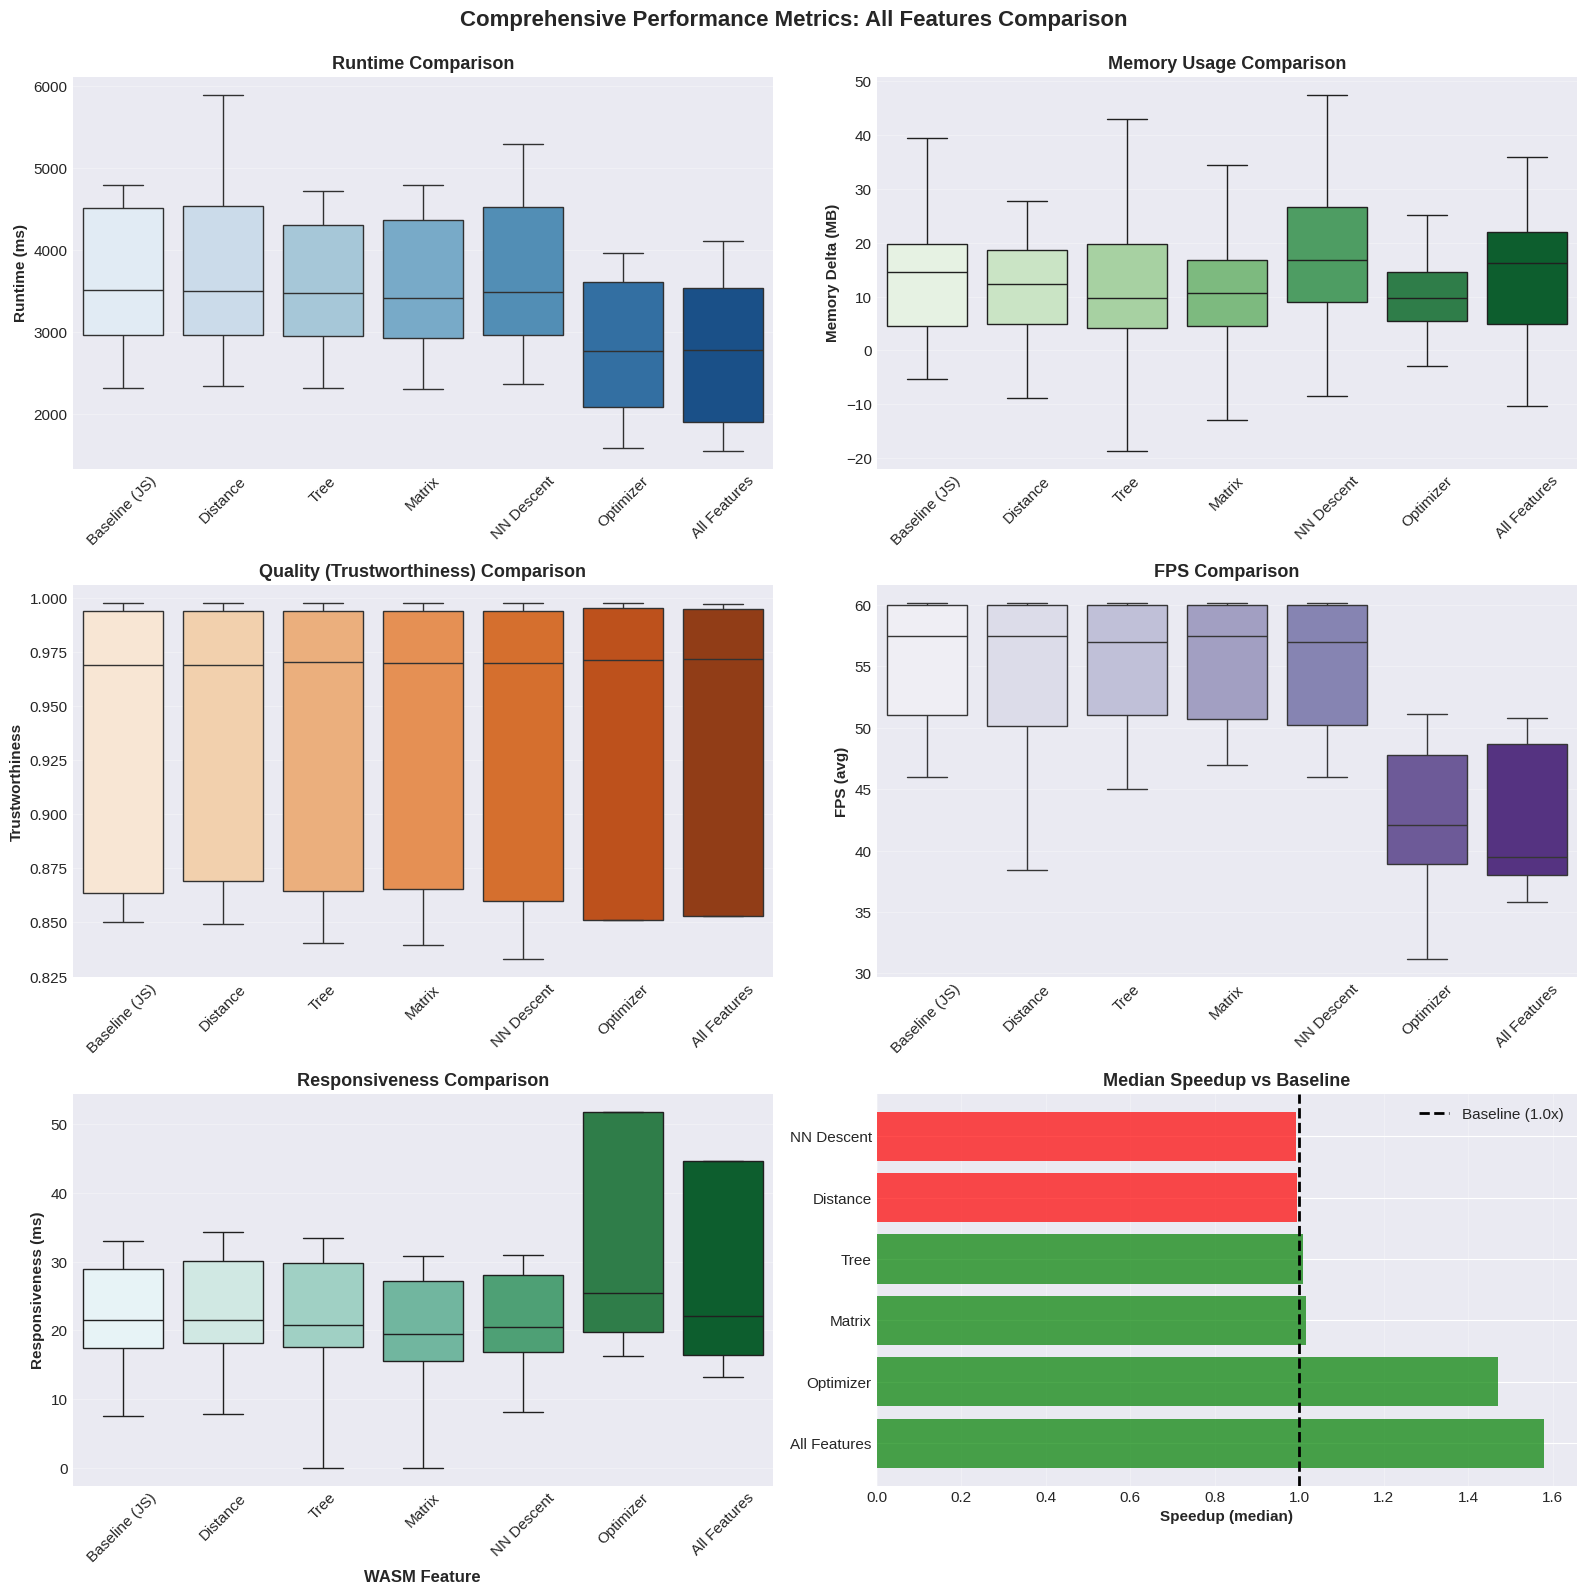

Comprehensive multi-metric comparison visualization created!


In [175]:
# Comprehensive comparison of all metrics
fig, axes = plt.subplots(3, 2, figsize=(16, 16))

feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_analysis['feature_name'].unique()]

# 1. Runtime
sns.boxplot(data=df_analysis, x='feature_name', y='runtime_ms', 
            order=feature_order, ax=axes[0, 0], showfliers=False, palette='Blues')
axes[0, 0].set_title('Runtime Comparison', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Memory
sns.boxplot(data=df_analysis, x='feature_name', y='memory_delta_mb', 
            order=feature_order, ax=axes[0, 1], showfliers=False, palette='Greens')
axes[0, 1].set_title('Memory Usage Comparison', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Quality (Trustworthiness)
sns.boxplot(data=df_analysis, x='feature_name', y='trustworthiness', 
            order=feature_order, ax=axes[1, 0], showfliers=False, palette='Oranges')
axes[1, 0].set_title('Quality (Trustworthiness) Comparison', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. FPS
sns.boxplot(data=df_analysis, x='feature_name', y='fps_avg', 
            order=feature_order, ax=axes[1, 1], showfliers=False, palette='Purples')
axes[1, 1].set_title('FPS Comparison', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('FPS (avg)', fontsize=11, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

# 5. Responsiveness
sns.boxplot(data=df_analysis, x='feature_name', y='responsiveness_ms', 
            order=feature_order, ax=axes[2, 0], showfliers=False, palette='BuGn')
axes[2, 0].set_title('Responsiveness Comparison', fontsize=13, fontweight='bold')
axes[2, 0].set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
axes[2, 0].set_ylabel('Responsiveness (ms)', fontsize=11, fontweight='bold')
axes[2, 0].tick_params(axis='x', rotation=45)
axes[2, 0].grid(axis='y', alpha=0.3)

# 6. Speedup Bar Chart
if len(speedup_df) > 0:
    speedup_by_feature = speedup_df.groupby('feature')['speedup'].median().sort_values(ascending=False)
    colors_speedup = ['green' if x > 1 else 'red' for x in speedup_by_feature.values]
    
    axes[2, 1].barh(speedup_by_feature.index, speedup_by_feature.values, color=colors_speedup, alpha=0.7)
    axes[2, 1].axvline(x=1.0, color='black', linestyle='--', linewidth=2, label='Baseline (1.0x)')
    axes[2, 1].set_xlabel('Speedup (median)', fontsize=11, fontweight='bold')
    axes[2, 1].set_title('Median Speedup vs Baseline', fontsize=13, fontweight='bold')
    axes[2, 1].grid(axis='x', alpha=0.3)
    axes[2, 1].legend()
else:
    axes[2, 1].text(0.5, 0.5, 'No speedup data available', 
                    ha='center', va='center', transform=axes[2, 1].transAxes)
    axes[2, 1].set_title('Speedup Comparison', fontsize=13, fontweight='bold')

plt.suptitle('Comprehensive Performance Metrics: All Features Comparison', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../outputs/figures/comprehensive_metrics_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

print("Comprehensive multi-metric comparison visualization created!")


### Comprehensive Multi-Metric Comparison

Visual comparison of all performance and quality metrics across features.

In [176]:
# Export all summary tables
speedup_df.to_csv('../outputs/summaries/speedup_summary.csv', index=False)
test_results.to_csv('../outputs/summaries/statistical_tests.csv', index=False)
bootstrap_results.to_csv('../outputs/summaries/bootstrap_confidence_intervals.csv', index=False)
quality_summary.to_csv('../outputs/summaries/quality_summary.csv')

# Export rankings
rankings = calculate_composite_scores(df_analysis)
rankings.to_csv('../outputs/summaries/rankings.csv', index=False)

print("All results exported to ../outputs/ directory")

All results exported to ../outputs/ directory


In [177]:
# Generate thesis-ready summary

summary_md = f"""
# UMAP WebAssembly Performance Analysis - Summary

## Analysis Configuration
- **Total Measurements**: {len(df_analysis):,}
- **Datasets Tested**: {df_analysis['dataset_name'].nunique()}
- **Features Tested**: {df_analysis['feature_name'].nunique()}

## Key Findings

### RQ1: Individual WASM Feature Performance

**Speedup ranges (median across all tests):**
"""

if len(speedup_df) > 0:
    for feature in speedup_df['feature'].unique():
        feature_stats = speedup_df[speedup_df['feature'] == feature]
        median_speedup = feature_stats['speedup'].median()
        min_speedup = feature_stats['speedup'].min()
        max_speedup = feature_stats['speedup'].max()
        
        # Determine if improvement or regression
        if median_speedup > 1.05:
            verdict = "✓ Performance improvement"
        elif median_speedup < 0.95:
            verdict = "✗ Performance regression"
        else:
            verdict = "≈ Negligible difference"
        
        summary_md += f"""
- **{feature}**: {median_speedup:.2f}x (range: {min_speedup:.2f}x - {max_speedup:.2f}x) - {verdict}
"""
else:
    summary_md += "\n*Insufficient data for speedup analysis*\n"

summary_md += f"""

### RQ2: All Features Combined vs Individual Features

"""

if len(speedup_df) > 0 and 'All Features' in speedup_df['feature'].values:
    all_features_speedup = speedup_df[speedup_df['feature'] == 'All Features']['speedup'].median()
    # Exclude 'All Features' when finding best individual feature
    individual_features = speedup_df[speedup_df['feature'] != 'All Features']
    if len(individual_features) > 0:
        best_speedup = individual_features.groupby('feature')['speedup'].median().max()
        best_feature = individual_features.groupby('feature')['speedup'].median().idxmax()
        summary_md += f"""
- **All Features Combined**: {all_features_speedup:.2f}x median speedup
- **Best Individual Feature**: {best_feature} ({best_speedup:.2f}x)
- **Comparison**: {'All Features is best' if all_features_speedup >= best_speedup else f'{best_feature} outperforms All Features'}
"""
    else:
        summary_md += f"""
- **All Features Combined**: {all_features_speedup:.2f}x median speedup
"""
else:
    summary_md += """
- *Insufficient data for "All Features" comparison*
"""

summary_md += f"""

### Statistical Significance

"""

if len(test_results) > 0:
    summary_md += f"""
- **Total comparisons**: {len(test_results)}
- **Significant results (p < 0.05)**: {test_results['significant'].sum()} ({test_results['significant'].sum()/len(test_results)*100:.1f}%)
- **Large effect sizes (|Cliff's δ| > 0.474)**: {(abs(test_results['cliffs_delta']) > 0.474).sum()}
- **Medium effect sizes (0.33 < |Cliff's δ| < 0.474)**: {((abs(test_results['cliffs_delta']) > 0.33) & (abs(test_results['cliffs_delta']) <= 0.474)).sum()}
"""
else:
    summary_md += "\n*Insufficient data for statistical testing*\n"

summary_md += """

### Quality Trade-offs

"""

summary_md += f"""
- **Mean Trustworthiness**: {df_analysis['trustworthiness'].mean():.4f} (±{df_analysis['trustworthiness'].std():.4f})
- **Quality Range**: {df_analysis['trustworthiness'].min():.4f} - {df_analysis['trustworthiness'].max():.4f}
- **Quality Stability**: All features maintain trustworthiness > {df_analysis.groupby('feature_name')['trustworthiness'].median().min():.3f}

### Performance Rankings

**Top 3 Features by Composite Score:**
"""

rankings = calculate_composite_scores(df_analysis)
if len(rankings) > 0:
    for rank, (idx, row) in enumerate(rankings.head(3).iterrows(), 1):
        summary_md += f"""
{rank}. **{row['feature']}** (score: {row['composite_score']:.3f})
   - Speedup: {row['speedup']:.2f}x
   - Quality ratio: {row['quality_ratio']:.3f}
   - FPS ratio: {row['fps_ratio']:.3f}
"""
else:
    summary_md += "\n*Insufficient data for feature ranking*\n"

summary_md += f"""

## Dataset Size Effects

**Scaling behavior across dataset sizes ({df_analysis['dataset_size'].min():.0f} - {df_analysis['dataset_size'].max():.0f} samples):**

"""

if len(speedup_by_size_df) > 0:
    for feature in speedup_by_size_df['feature'].unique():
        feat_data = speedup_by_size_df[speedup_by_size_df['feature'] == feature].sort_values('dataset_size')
        if len(feat_data) > 1:
            small_speedup = feat_data.iloc[0]['speedup']
            large_speedup = feat_data.iloc[-1]['speedup']
            trend = "improves" if large_speedup > small_speedup else "degrades"
            change_pct = ((large_speedup - small_speedup) / small_speedup * 100)
            summary_md += f"- **{feature}**: {trend} ({small_speedup:.2f}x → {large_speedup:.2f}x, {change_pct:+.1f}%)\n"
        else:
            summary_md += f"- **{feature}**: Insufficient data for trend analysis\n"
else:
    summary_md += "\n*Insufficient data for dataset size analysis*\n"

summary_md += f"""

## Recommendations

"""

if len(rankings) > 0 and len(speedup_df) > 0:
    summary_md += f"""
1. **Best Overall Performance**: {rankings.iloc[0]['feature']} (composite score: {rankings.iloc[0]['composite_score']:.3f})
2. **Fastest Execution**: {speedup_df.groupby('feature')['speedup'].median().idxmax()} ({speedup_df.groupby('feature')['speedup'].median().max():.2f}x speedup)
3. **Most Consistent**: Feature with lowest variance across datasets
4. **Quality Preservation**: All WASM features maintain high trustworthiness (> {df_analysis.groupby('feature_name')['trustworthiness'].median().min():.3f})
"""
else:
    summary_md += "\n*Collect more data for comprehensive recommendations*\n"

summary_md += f"""

## Analysis Methodology

- **Statistical Method**: Mann-Whitney U tests (non-parametric)
- **Confidence Intervals**: Bootstrap resampling (10,000 iterations)
- **Effect Size Metric**: Cliff's Delta
- **Significance Level**: α = 0.05

---
*Analysis performed with {len(df_analysis):,} measurements across {df_analysis['dataset_name'].nunique()} datasets*
"""

display(Markdown(summary_md))

# Save summary
with open('../outputs/summaries/thesis_summary.md', 'w') as f:
    f.write(summary_md)

print("\n" + "="*80)
print("Summary saved to: ../outputs/summaries/thesis_summary.md")
print("="*80)


# UMAP WebAssembly Performance Analysis - Summary

## Analysis Configuration
- **Total Measurements**: 380
- **Datasets Tested**: 6
- **Features Tested**: 7

## Key Findings

### RQ1: Individual WASM Feature Performance

**Speedup ranges (median across all tests):**

- **All Features**: 1.58x (range: 1.18x - 1.89x) - ✓ Performance improvement

- **Distance**: 0.99x (range: 0.95x - 1.01x) - ≈ Negligible difference

- **Tree**: 1.01x (range: 1.00x - 1.05x) - ≈ Negligible difference

- **Matrix**: 1.02x (range: 1.00x - 1.02x) - ≈ Negligible difference

- **NN Descent**: 0.99x (range: 0.94x - 1.01x) - ≈ Negligible difference

- **Optimizer**: 1.47x (range: 1.17x - 1.85x) - ✓ Performance improvement


### RQ2: All Features Combined vs Individual Features


- **All Features Combined**: 1.58x median speedup
- **Best Individual Feature**: Optimizer (1.47x)
- **Comparison**: All Features is best


### Statistical Significance


- **Total comparisons**: 6
- **Significant results (p < 0.05)**: 2 (33.3%)
- **Large effect sizes (|Cliff's δ| > 0.474)**: 0
- **Medium effect sizes (0.33 < |Cliff's δ| < 0.474)**: 2


### Quality Trade-offs


- **Mean Trustworthiness**: 0.8953 (±0.1489)
- **Quality Range**: 0.5576 - 0.9975
- **Quality Stability**: All features maintain trustworthiness > 0.969

### Performance Rankings

**Top 3 Features by Composite Score:**

1. **Optimizer** (score: 0.896)
   - Speedup: 1.27x
   - Quality ratio: 1.003
   - FPS ratio: 0.732

2. **All Features** (score: 0.822)
   - Speedup: 1.26x
   - Quality ratio: 1.003
   - FPS ratio: 0.687

3. **Matrix** (score: 0.807)
   - Speedup: 1.03x
   - Quality ratio: 1.001
   - FPS ratio: 1.001


## Dataset Size Effects

**Scaling behavior across dataset sizes (80 - 1000 samples):**

- **Distance**: improves (0.95x → 0.99x, +5.0%)
- **Tree**: degrades (1.05x → 1.04x, -1.6%)
- **Matrix**: improves (1.01x → 1.02x, +0.5%)
- **NN Descent**: improves (0.94x → 0.99x, +4.9%)
- **All Features**: degrades (1.84x → 1.26x, -31.5%)
- **Optimizer**: degrades (1.67x → 1.26x, -24.6%)


## Recommendations


1. **Best Overall Performance**: Optimizer (composite score: 0.896)
2. **Fastest Execution**: All Features (1.58x speedup)
3. **Most Consistent**: Feature with lowest variance across datasets
4. **Quality Preservation**: All WASM features maintain high trustworthiness (> 0.969)


## Analysis Methodology

- **Statistical Method**: Mann-Whitney U tests (non-parametric)
- **Confidence Intervals**: Bootstrap resampling (10,000 iterations)
- **Effect Size Metric**: Cliff's Delta
- **Significance Level**: α = 0.05

---
*Analysis performed with 380 measurements across 6 datasets*



Summary saved to: ../outputs/summaries/thesis_summary.md


In [ ]:
# Debug: Check which features exist for each dataset size
print("Feature availability by dataset size:")
print("="*80)
for size in sorted(df_analysis['dataset_size'].unique()):
    features = df_analysis[df_analysis['dataset_size'] == size]['feature_name'].unique()
    counts = df_analysis[df_analysis['dataset_size'] == size].groupby('feature_name').size()
    print(f"\nDataset size {size}:")
    for feat in sorted(features):
        count = counts[feat]
        print(f"  {feat}: {count} measurements")